In [1]:
#setting working directory
setwd("~/INF_analysis/")

In [2]:
#setting the general options
options(timeout = 200)
options(repr.plot.width=5, repr.plot.height=5)

In [3]:
#importing the libraries
library(Seurat)
library(DropletUtils)
library(scater)
library(dplyr)
library(Azimuth)
library(EnhancedVolcano)
library(plyr)
library(readxl)
library(future)
library(ggplot2)
library(data.table)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, 

In [4]:
#general plotting settings
theme_set(theme_bw())
theme_update(axis.text = element_text(color="black"),
              panel.grid.minor = element_blank(), 
             text = element_text(size=12))

pdf.options(useDingbats=FALSE)

In [5]:
#loading the data
load("unc93B1_H12_noXCR.integrated_SNN_rpca_50.RData")

In [6]:
#loading the annotations
annotation<- read_excel("cluster_annotation_0.8res_ccg.xlsx")
annotation <- as.data.frame(annotation)
row.names(annotation) <- annotation$Cluster

In [7]:
#seurat_obj <- CreateSeuratObject(counts = SO.integrated$RNA,, min.cells = 3, min.features = 200)

In [8]:
#assigning the main annotation
SO.integrated@meta.data$cluster_annotation<-annotation[as.character(SO.integrated@meta.data$`integrated_snn_res.0.8`),"name"]

In [9]:
#reassigning the participant names
unique(SO.integrated@meta.data$experiment)
SO.integrated@meta.data$status <- SO.integrated@meta.data$experiment
SO.integrated@meta.data$status<-sub("LK120203_unc93b1","Patient",SO.integrated@meta.data$status)
SO.integrated@meta.data$status<-sub("Hashtag-1","CTRL1",SO.integrated@meta.data$status)
SO.integrated@meta.data$status<-sub("Hashtag-2","CTRL2",SO.integrated@meta.data$status)


unique(SO.integrated@meta.data$status)

[1] "LK120203_unc93b1" "E7H9_unc93b1"     "Hashtag-1"        "Hashtag-2"

[1] "Patient"      "E7H9_unc93b1" "CTRL1"        "CTRL2"

In [10]:
#filtering low quality droplets, etc
SO.integrated<- subset(x = SO.integrated, subset = cluster_annotation != "low quality monocytes")
SO.integrated<- subset(x = SO.integrated, subset = cluster_annotation != "low quality T cells")
SO.integrated<- subset(x = SO.integrated, subset = cluster_annotation != "low quality B cells")
SO.integrated<- subset(x = SO.integrated, subset = cluster_annotation != "B cell / T cell doublets")
SO.integrated<- subset(x = SO.integrated, subset = cluster_annotation != "monocyte / B cell doublets")
SO.integrated<- subset(x = SO.integrated, subset = cluster_annotation != "double negative T cells")
SO.integrated<- subset(x = SO.integrated, subset = cluster_annotation != "Plasmablasts")
SO.integrated<- subset(x = SO.integrated, subset = cluster_annotation != "platelets")
SO.integrated<- subset(x = SO.integrated, subset = cluster_annotation != "pre-dendritic cells")
SO.integrated<- subset(x = SO.integrated, subset = cluster_annotation != "T cell / dendritic cell clusters")
SO.integrated<- subset(x = SO.integrated, subset = cluster_annotation != "AXL+ SIGLEC6+ pre dendritic cells")
SO.integrated<- subset(x = SO.integrated, subset = cluster_annotation != "mitochodria particles")



SO.integrated<- subset(x = SO.integrated, subset = experiment != "E7H9_unc93b1")


In [11]:
#setting the final working annotation
SO.integrated@meta.data$new_Annotation <- SO.integrated@meta.data$cluster_annotation

In [12]:
#renaming the annotations
SO.integrated@meta.data$new_Annotation<- sub("atypical memory B cells","B",SO.integrated@meta.data$new_Annotation)
SO.integrated@meta.data$new_Annotation <- sub("non-classical monocytes","CD16+ Mono",SO.integrated@meta.data$new_Annotation)
SO.integrated@meta.data$new_Annotation<- sub("germincal center activated / transitional B cells","B",SO.integrated@meta.data$new_Annotation)
SO.integrated@meta.data$new_Annotation<- sub("memory B cells","B",SO.integrated@meta.data$new_Annotation)
SO.integrated@meta.data$new_Annotation <- sub("CD4\\+ effector T cells \\(including Tregs\\)","CD4+T",SO.integrated@meta.data$new_Annotation)
SO.integrated@meta.data$new_Annotation <- sub("TNFα\\+ CD4 effector T cells","CD4+T",SO.integrated@meta.data$new_Annotation)
SO.integrated@meta.data$new_Annotation <- sub("activated CD8\\+ effector T cells \\(including NKT cells\\)","CD8+T",SO.integrated@meta.data$new_Annotation)
SO.integrated@meta.data$new_Annotation <- sub("IFN\\-primed classical monocytes","CD14+ Mono",SO.integrated@meta.data$new_Annotation)
SO.integrated@meta.data$new_Annotation <- sub("classical monocytes","CD14+ Mono",SO.integrated@meta.data$new_Annotation)
SO.integrated@meta.data$new_Annotation <- sub("conventional dendritic cells","cDCs",SO.integrated@meta.data$new_Annotation)
SO.integrated@meta.data$new_Annotation <- sub("intermediate monocytes","CD14+16+ Mono",SO.integrated@meta.data$new_Annotation)

SO.integrated@meta.data$new_Annotation <- sub("central memory like T cells","cm-like T",SO.integrated@meta.data$new_Annotation)

SO.integrated@meta.data$new_Annotation <- sub("plasmocitoid dendritic cells","pDCs",SO.integrated@meta.data$new_Annotation)
SO.integrated@meta.data$new_Annotation <- sub("proliferating T cells","prolif T",SO.integrated@meta.data$new_Annotation)


In [13]:
SO.integrated@meta.data$minimal_status <- SO.integrated@meta.data$experiment
SO.integrated@meta.data$minimal_status <- sub("LK120203_unc93b1","Patient",SO.integrated@meta.data$minimal_status)
SO.integrated@meta.data$minimal_status <- sub("Hashtag-1","CTRL",SO.integrated@meta.data$minimal_status)
SO.integrated@meta.data$minimal_status <- sub("Hashtag-2","CTRL",SO.integrated@meta.data$minimal_status)


In [14]:
SO.integrated@meta.data$minimal_status_cell_type <- paste0(SO.integrated@meta.data$minimal_status,"_",SO.integrated@meta.data$new_Annotation)
SO.integrated@meta.data$status_cell_type <- paste0(SO.integrated@meta.data$status,"_",SO.integrated@meta.data$new_Annotation)


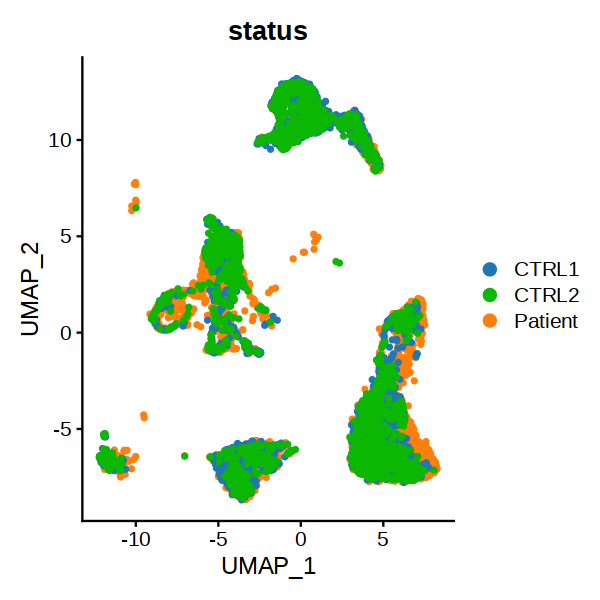

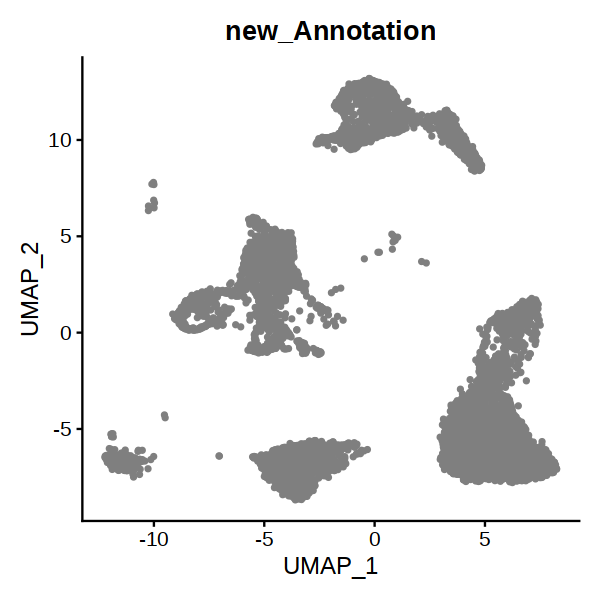

In [15]:
#plotting the UMAPs of the data based on the donors
#dir.create(tempdir())
status_colors<- c("Patient" = "#FF7F0E", "CTRL1" = "#1F77B4", "CTRL2" = "#0CB702")
#pdf("UMAPSSS.pdf",height=5,width = 5)
DimPlot(SO.integrated, reduction = "umap",cols=status_colors,group.by = "status",pt.size = 1,raster.dpi=c(500,500))
DimPlot(SO.integrated, reduction = "umap",cols=status_colors,group.by = "new_Annotation",pt.size = 1,raster.dpi=c(500,500))

#dev.off()

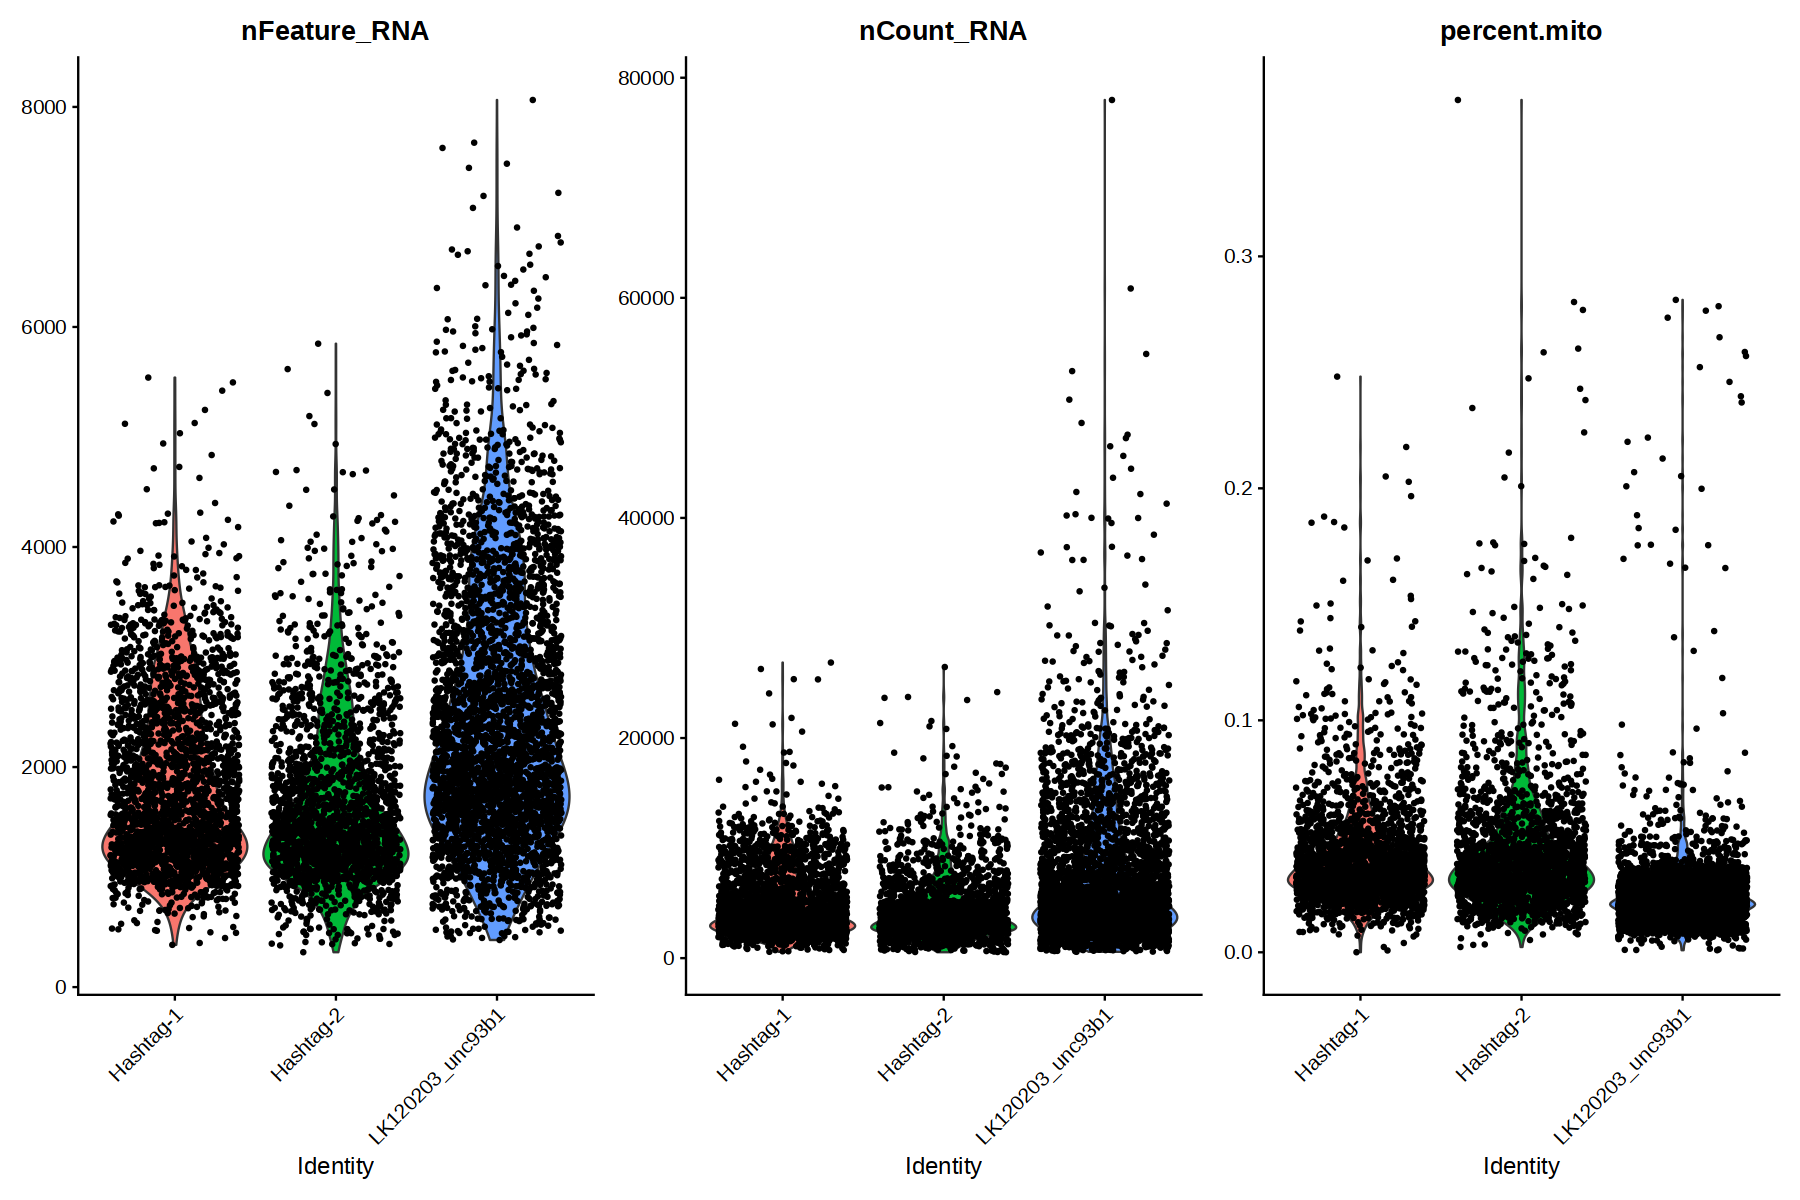

In [16]:
# Visualize QC metrics as a violin plot
options(repr.plot.width = 15, repr.plot.height = 10)

VlnPlot(SO.integrated, features = c("nFeature_RNA", "nCount_RNA", "percent.mito"), ncol = 3,group.by = "experiment")

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


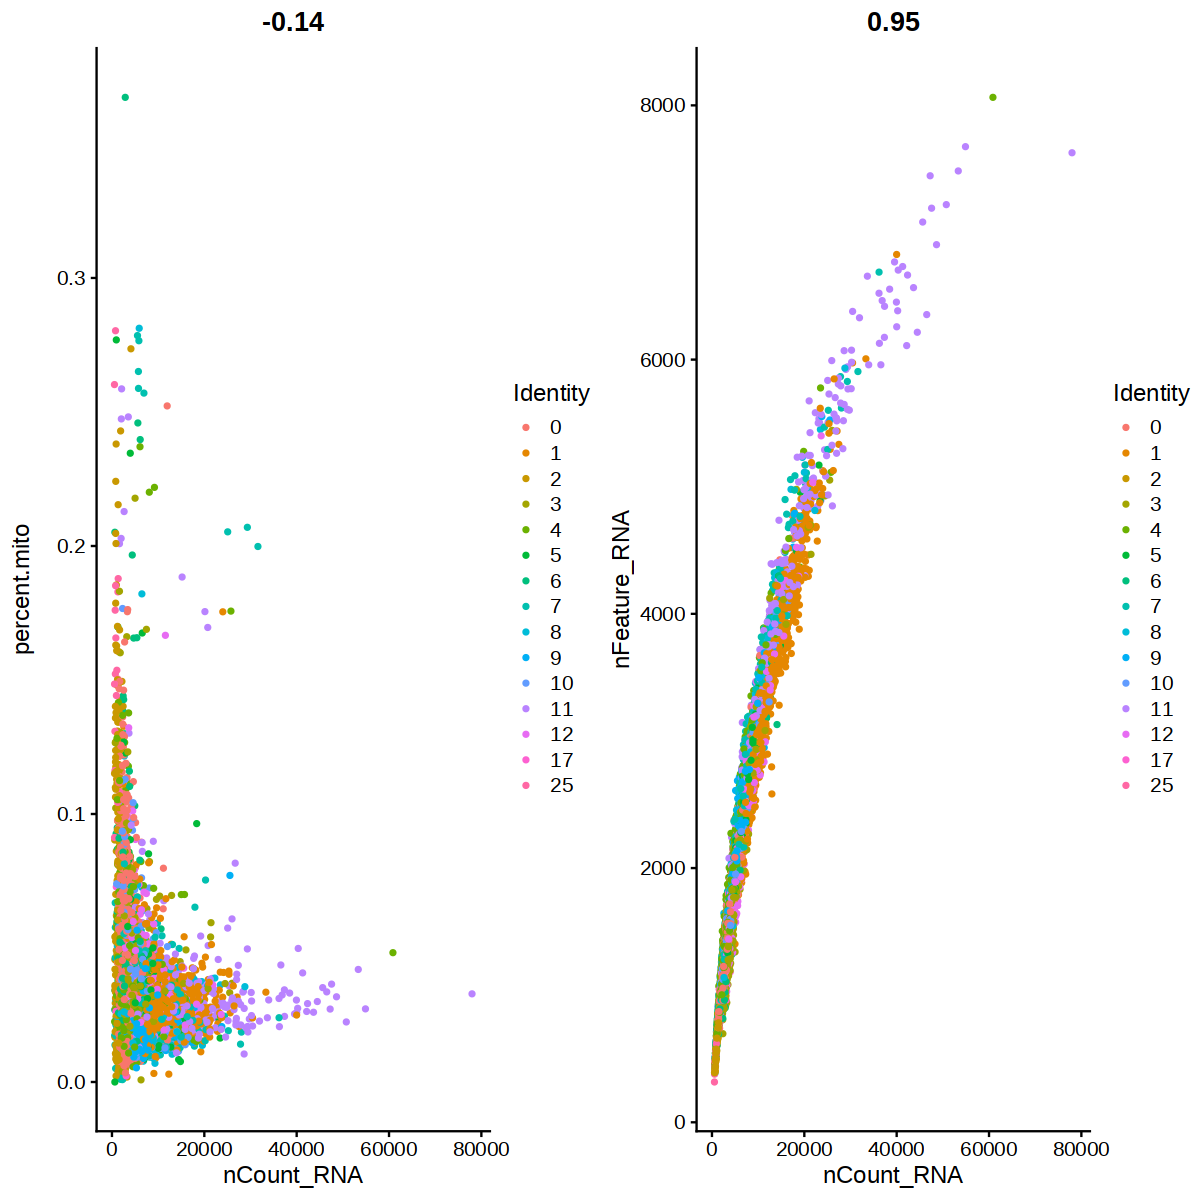

In [17]:
#visializing the QC metrics as scatter plots
options(repr.plot.width = 10, repr.plot.height = 10)
plot1 <- FeatureScatter(SO.integrated, feature1 = "nCount_RNA", feature2 = "percent.mito")
plot2 <- FeatureScatter(SO.integrated, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
CombinePlots(plots = list(plot1, plot2))

null device 
          1

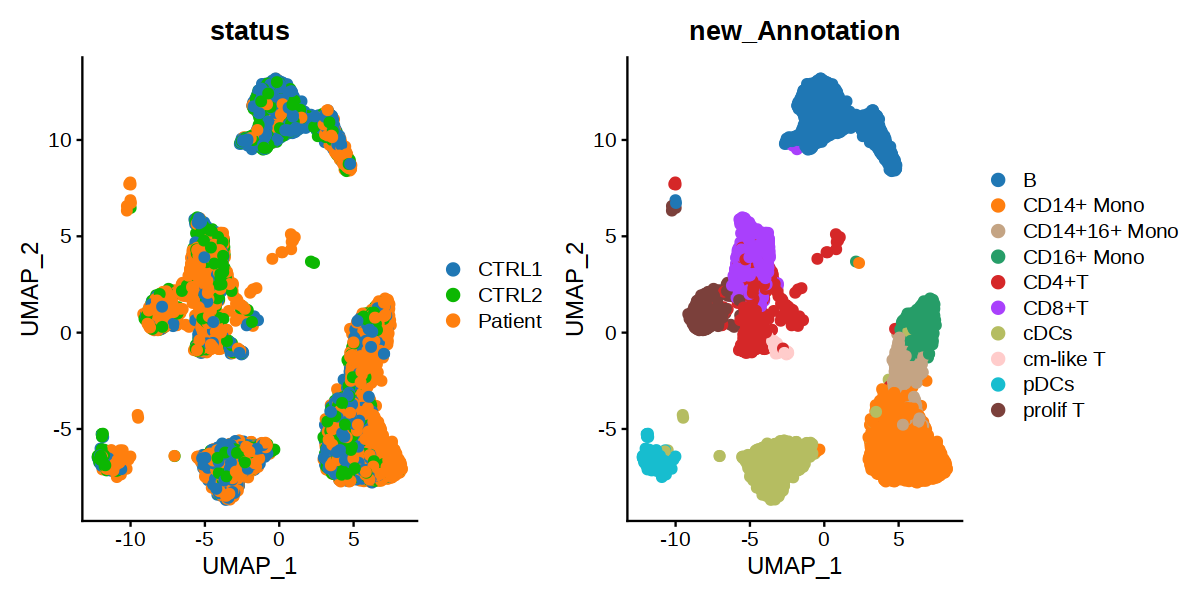

In [18]:
options(repr.plot.width = 10, repr.plot.height = 5)
cell_type_colors <- c("CD14+ Mono" = "#ff7e0e", "B" = "#1f77b4", "CD8+T" = "#a940fc","CD16+ Mono"="#269d68",
                  "prolif T"="#7B403B","CD14+16+ Mono"="#C4A484","CD4+T"="#d52728","cm-like T"="#FFCCCB",
                   "cDCs"="#b5bd61","pDCs"="#17bdcf")

#pdf("supp_plots/UMAP_extension.pdf",height=10,width = 20)

P1=DimPlot(SO.integrated, reduction = "umap",cols=alpha(status_colors),group.by = "status",pt.size = 2.3,raster.dpi=c(500,500),shuffle = TRUE)
          
P2=DimPlot(SO.integrated, reduction = "umap",cols=cell_type_colors,group.by = "new_Annotation",pt.size = 2.3,raster.dpi=c(500,500),shuffle = TRUE)
#options(repr.plot.width = 5, repr.plot.height = 5)

P1+P2
dev.off()

In [19]:
#SO.integrated <- NormalizeData(SO.integrated)


In [20]:
#plan("multiprocess", workers = 4)
#SO.integrated <- NormalizeData(SO.integrated, normalization.method = "LogNormalize", scale.factor = 10000)
#SO.integrated <- NormalizeData(SO.integrated)


In [21]:
#SO.integrated <- FindVariableFeatures(SO.integrated, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
#top10 <- head(VariableFeatures(SO.integrated), 10)

# plot variable features with and without labels
#plot1 <- VariableFeaturePlot(SO.integrated)
#plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
#CombinePlots(plots = list(plot1, plot2))

In [22]:
all.genes <- rownames(SO.integrated)
#SO.integrated <- ScaleData(SO.integrated, features = all.genes)

In [23]:
Idents(SO.integrated) <- SO.integrated@meta.data$minimal_status_cell_type

In [24]:
#defining the signature genes
cytotoxic_signature = c("PRF1", "GZMH", "GZMB")
exhaustion_signature = c("PDCD1", "CTLA4", "LAG3", "CD160", "TIGIT", "HAVCR2", "CD244")
type_1_ISG_signature = c("ISG15", "IFI6", "IFI44L", "IFI44", "RSAD2", "CXCL10", "IFIT2", "IFIT3", "IFIT1", "IFITM3", 
                        "OAS1", "OAS3", "OAS2", "OASL", "EPSTI1", 
                        "RNASE1", "RNASE2", "IFI27", "XAF1", "LGALS3BP", "SIGLEC1", "USP18", "APOBEC3A", "APOBEC3B", "MX1")


In [25]:
#visualizing the dot plots of the signatuires scores across cell types
SO.integrated_dot_plot <- SO.integrated
SO.integrated_dot_plot@meta.data$dotplot_annotation <- SO.integrated_dot_plot@meta.data$minimal_status_cell_type
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("CTRL_pDCs","pDCs_co",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("Patient_pDCs","pDCs_pat",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("CTRL_cDCs","cDCs_co",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("Patient_cDCs","cDCs_pat",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("CTRL_CD14\\+ Mono","CD14+Mono_co",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("Patient_CD14\\+ Mono","CD14+Mono_pat",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("CTRL_CD14\\+16\\+ Mono","CD14+16+Mono_co",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("Patient_CD14\\+16\\+ Mono","CD14+16+Mono_pat",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("CTRL_CD16\\+ Mono","CD16+Mono_co",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("Patient_CD16\\+ Mono","CD16+Mono_pat",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("CTRL_prolif T","prolif T_co",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("Patient_prolif T","prolif T_pat",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("CTRL_cm\\-like T","cm-like T_co",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("Patient_cm\\-like T","cm-like T_pat",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("CTRL_CD8\\+T","CD8+T_co",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("Patient_CD8\\+T","CD8+T_pat",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("CTRL_CD4\\+T","CD4+T_co",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("Patient_CD4\\+T","CD4+T_pat",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("CTRL_B","B_co",SO.integrated_dot_plot@meta.data$dotplot_annotation)
SO.integrated_dot_plot@meta.data$dotplot_annotation <- sub("Patient_B","B_pat",SO.integrated_dot_plot@meta.data$dotplot_annotation)


Idents(SO.integrated_dot_plot) <- SO.integrated_dot_plot@meta.data$dotplot_annotation

levels(SO.integrated_dot_plot)<- c("pDCs_co","pDCs_pat","cDCs_co","cDCs_pat","CD14+Mono_co","CD14+Mono_pat",
                         "CD14+16+Mono_co","CD14+16+Mono_pat","CD16+Mono_co","CD16+Mono_pat",
                         "prolif T_co","prolif T_pat","cm-like T_co","cm-like T_pat","CD8+T_co","CD8+T_pat",
                         "CD4+T_co","CD4+T_pat","B_co","B_pat")




pdf("supp_plots/dotplots.pdf",width = 13,height = 6)
p1 = DotPlot(
  object=SO.integrated_dot_plot,
  assay = "RNA",
  features=c("TLR3", "TLR7", "TLR8","TLR9"),
  cols = c("white", "#bc141a"),
  col.min = -2.5,
  col.max = 2.5,
  dot.min = 0,
  dot.scale = 7,
  idents=NULL,
  group.by = NULL,
  split.by = NULL,
  cluster.idents = FALSE,
  scale = TRUE,
  scale.by = "radius",
  scale.min = NA,
  scale.max = NA
)+geom_point(aes(size=pct.exp), shape = 21, colour="black", stroke=0.5) +
  #scale_colour_viridis(option="magma") +
  guides(size=guide_legend(override.aes=list(shape=21, colour="black", fill="white")))+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

p2= DotPlot(
  object=SO.integrated_dot_plot,
  assay = "RNA",
  features=c("UNC93B1"),
  cols = c("white", "#bc141a"),
  col.min = -2.5,
  col.max = 2.5,
  dot.min = 0,
  dot.scale = 7,
  idents=NULL,
  group.by = NULL,
  split.by = NULL,
  cluster.idents = FALSE,
  scale = TRUE,
  scale.by = "radius",
  scale.min = NA,
  scale.max = NA
)+geom_point(aes(size=pct.exp), shape = 21, colour="black", stroke=0.5) +
  #scale_colour_viridis(option="magma") +
  guides(size=guide_legend(override.aes=list(shape=21, colour="black", fill="white")))+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

p1+p2
dev.off()


pdf("supp_plots/ISGs_across_cell_types_dotplot.pdf",width = 10,height = 10)
DotPlot(
  object=SO.integrated_dot_plot,
  assay = "RNA",
  features=type_1_ISG_signature,
  cols = c("white", "#bc141a"),
  col.min = -2.5,
  col.max = 2.5,
  dot.min = 0,
  dot.scale = 7,
  idents=NULL,
  group.by = NULL,
  split.by = NULL,
  cluster.idents = FALSE,
  scale = TRUE,
  scale.by = "radius",
  scale.min = NA,
  scale.max = NA
)+geom_point(aes(size=pct.exp), shape = 21, colour="black", stroke=0.5) +
  #scale_colour_viridis(option="magma") +
  guides(size=guide_legend(override.aes=list(shape=21, colour="black", fill="white")))+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
dev.off()

png 
  2

png 
  2

In [26]:
#identifying differentially expressed genes
SO.integrated.markers <- FindAllMarkers(SO.integrated, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster Patient_cDCs

Calculating cluster Patient_CD4+T

Calculating cluster Patient_CD14+ Mono

Calculating cluster Patient_B

Calculating cluster Patient_CD8+T

Calculating cluster Patient_CD16+ Mono

Calculating cluster Patient_pDCs

Calculating cluster Patient_CD14+16+ Mono

Calculating cluster Patient_prolif T

Calculating cluster Patient_cm-like T

Calculating cluster CTRL_cDCs

Calculating cluster CTRL_CD14+ Mono

Calculating cluster CTRL_B

Calculating cluster CTRL_prolif T

Calculating cluster CTRL_CD4+T

Calculating cluster CTRL_pDCs

Calculating cluster CTRL_CD14+16+ Mono

Calculating cluster CTRL_CD8+T

Calculating cluster CTRL_CD16+ Mono

Calculating cluster CTRL_cm-like T



In [27]:
SO.integrated.markers$cluster_annotation<-annotation[as.character(SO.integrated.markers$cluster),"name"]

In [28]:
#subsetting the CD8+T cells
SO.integrated_CD8 <- subset(x = SO.integrated, subset = new_Annotation == "CD8+T")

In [29]:
#calculating the signatuire scores CD8+T cells
SO.integrated_CD8<- AddModuleScore(SO.integrated_CD8,features=list(cytotoxic_signature),name = "cytotoxic_signature",assay="RNA")
SO.integrated_CD8<- AddModuleScore(SO.integrated_CD8,features=list(exhaustion_signature),name = "exhaustion_signature",assay="RNA")
SO.integrated_CD8<- AddModuleScore(SO.integrated_CD8,features=list(type_1_ISG_signature),name = "type_1_ISG_signature",assay="RNA")



SO.integrated_CD8_melted <- melt(SO.integrated_CD8@meta.data[,c("cytotoxic_signature1","new_Annotation","status",
                                                               "exhaustion_signature1","type_1_ISG_signature1")])


Warning message in melt(SO.integrated_CD8@meta.data[, c("cytotoxic_signature1", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(SO.integrated_CD8@meta.data[, c("cytotoxic_signature1", "new_Annotation",     "status", "exhaustion_signature1", "type_1_ISG_signature1")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



In [30]:
#running wilcoxon rank sum terst of the the signatuire genes in CD8+T cells

#SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status=="Patient","minimal_status_cell_type"]
wilcox.test(SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status=="Patient","cytotoxic_signature1"],
           SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status=="CTRL1","cytotoxic_signature1"],exact=TRUE)

wilcox.test(SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status=="Patient","cytotoxic_signature1"],
           SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status=="CTRL2","cytotoxic_signature1"],exact=TRUE)

wilcox.test(SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status=="Patient","exhaustion_signature1"],
           SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status=="CTRL1","exhaustion_signature1"],exact=TRUE)

wilcox.test(SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status=="Patient","exhaustion_signature1"],
           SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status=="CTRL2","exhaustion_signature1"],exact=TRUE)

wilcox.test(SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status=="Patient","type_1_ISG_signature1"],
           SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status=="CTRL1","type_1_ISG_signature1"],exact=TRUE)

wilcox.test(SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status=="Patient","type_1_ISG_signature1"],
           SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status=="CTRL2","type_1_ISG_signature1"],exact=TRUE)


	Wilcoxon rank sum exact test

data:  SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status == "Patient", "cytotoxic_signature1"] and SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status == "CTRL1", "cytotoxic_signature1"]
W = 41058, p-value = 1.5e-05
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status == "Patient", "cytotoxic_signature1"] and SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status == "CTRL2", "cytotoxic_signature1"]
W = 94470, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status == "Patient", "exhaustion_signature1"] and SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status == "CTRL1", "exhaustion_signature1"]
W = 34349, p-value = 0.5377
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status == "Patient", "exhaustion_signature1"] and SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status == "CTRL2", "exhaustion_signature1"]
W = 65560, p-value = 0.6987
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status == "Patient", "type_1_ISG_signature1"] and SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status == "CTRL1", "type_1_ISG_signature1"]
W = 63288, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status == "Patient", "type_1_ISG_signature1"] and SO.integrated_CD8@meta.data[SO.integrated_CD8@meta.data$status == "CTRL2", "type_1_ISG_signature1"]
W = 127127, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


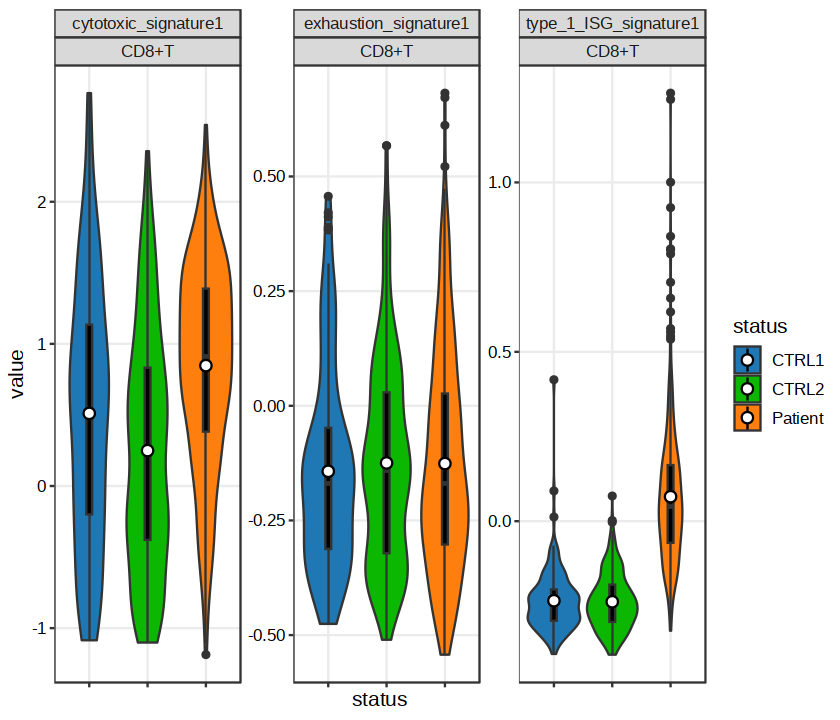

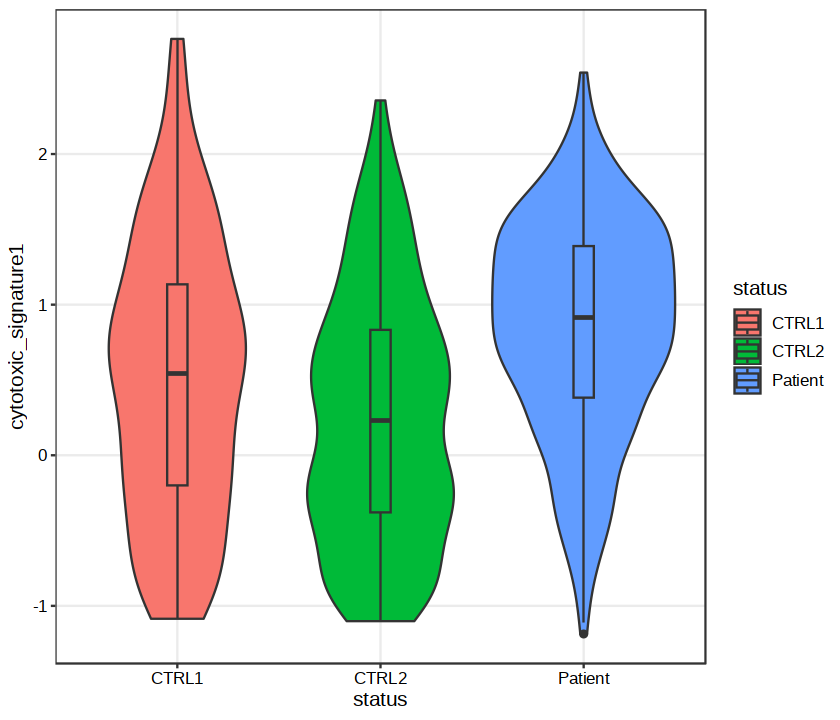

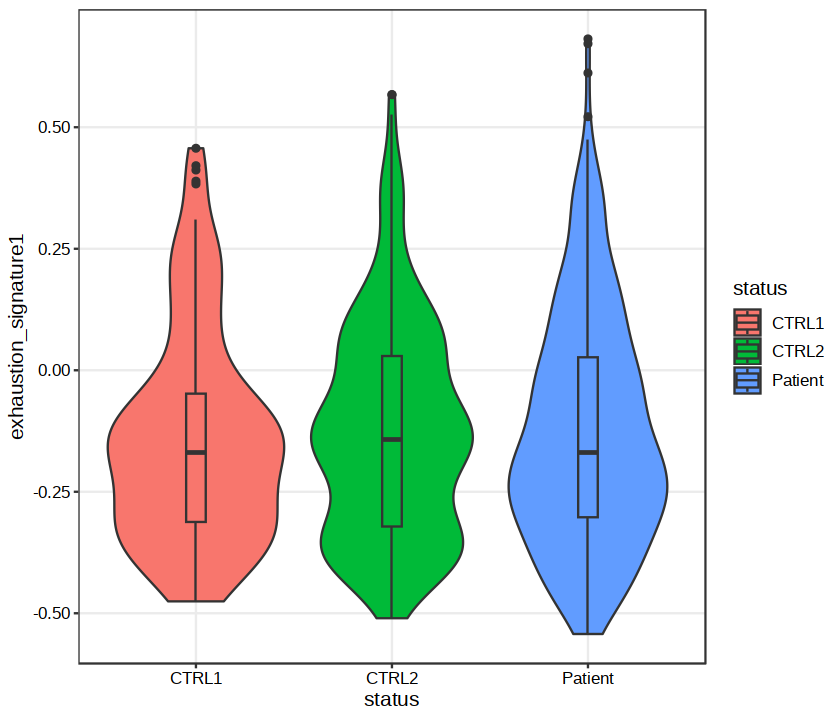

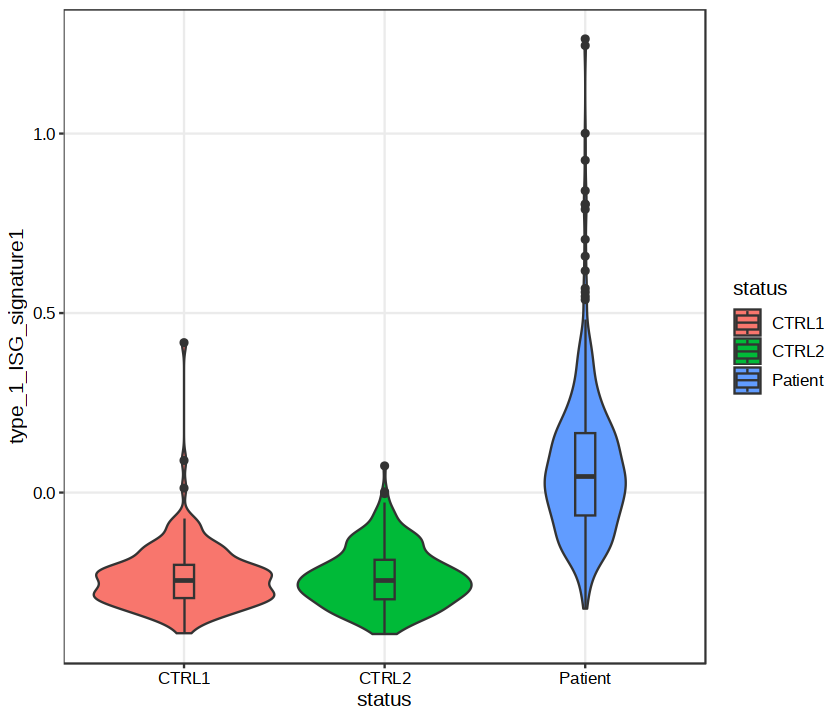

In [31]:
#visualizing the signatuire scores in CD8+T cells
options(repr.plot.width = 7, repr.plot.height = 6)


#pdf("supp_plots/CD8_sigs.pdf",height=4,width = 8)


ggplot(SO.integrated_CD8_melted,aes(y=value,x=status,fill=status))+geom_violin()+geom_boxplot(width=0.1,fill="black")+facet_wrap(~variable+new_Annotation,scales = "free_y")+stat_summary()+
scale_fill_manual(values=status_colors)+
  stat_summary(fun=mean, geom="point",color="white")+theme(axis.line=element_blank(),axis.text.x=element_blank())

#dev.off()

ggplot(SO.integrated_CD8@meta.data,aes(x=status,y=cytotoxic_signature1,
                                     fill=status))+
geom_violin()+geom_boxplot(width=0.1)

ggplot(SO.integrated_CD8@meta.data,aes(x=status,y=exhaustion_signature1,
                                     fill=status))+
geom_violin()+geom_boxplot(width=0.1)

ggplot(SO.integrated_CD8@meta.data,aes(x=status,y=type_1_ISG_signature1,
                                     fill=status))+
geom_violin()+geom_boxplot(width=0.1)

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


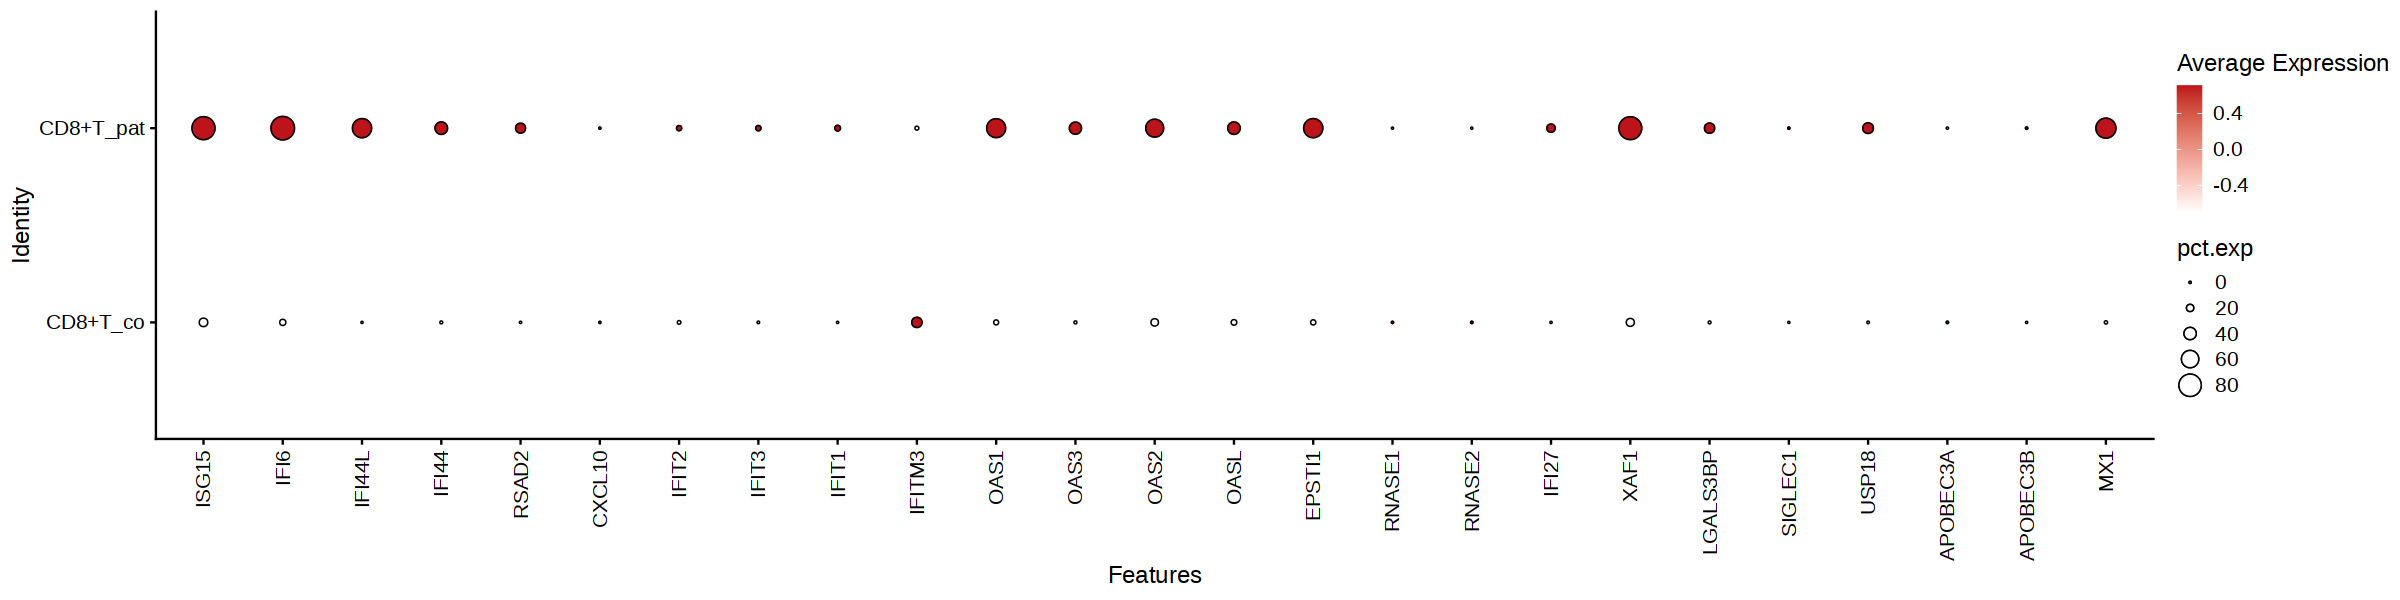

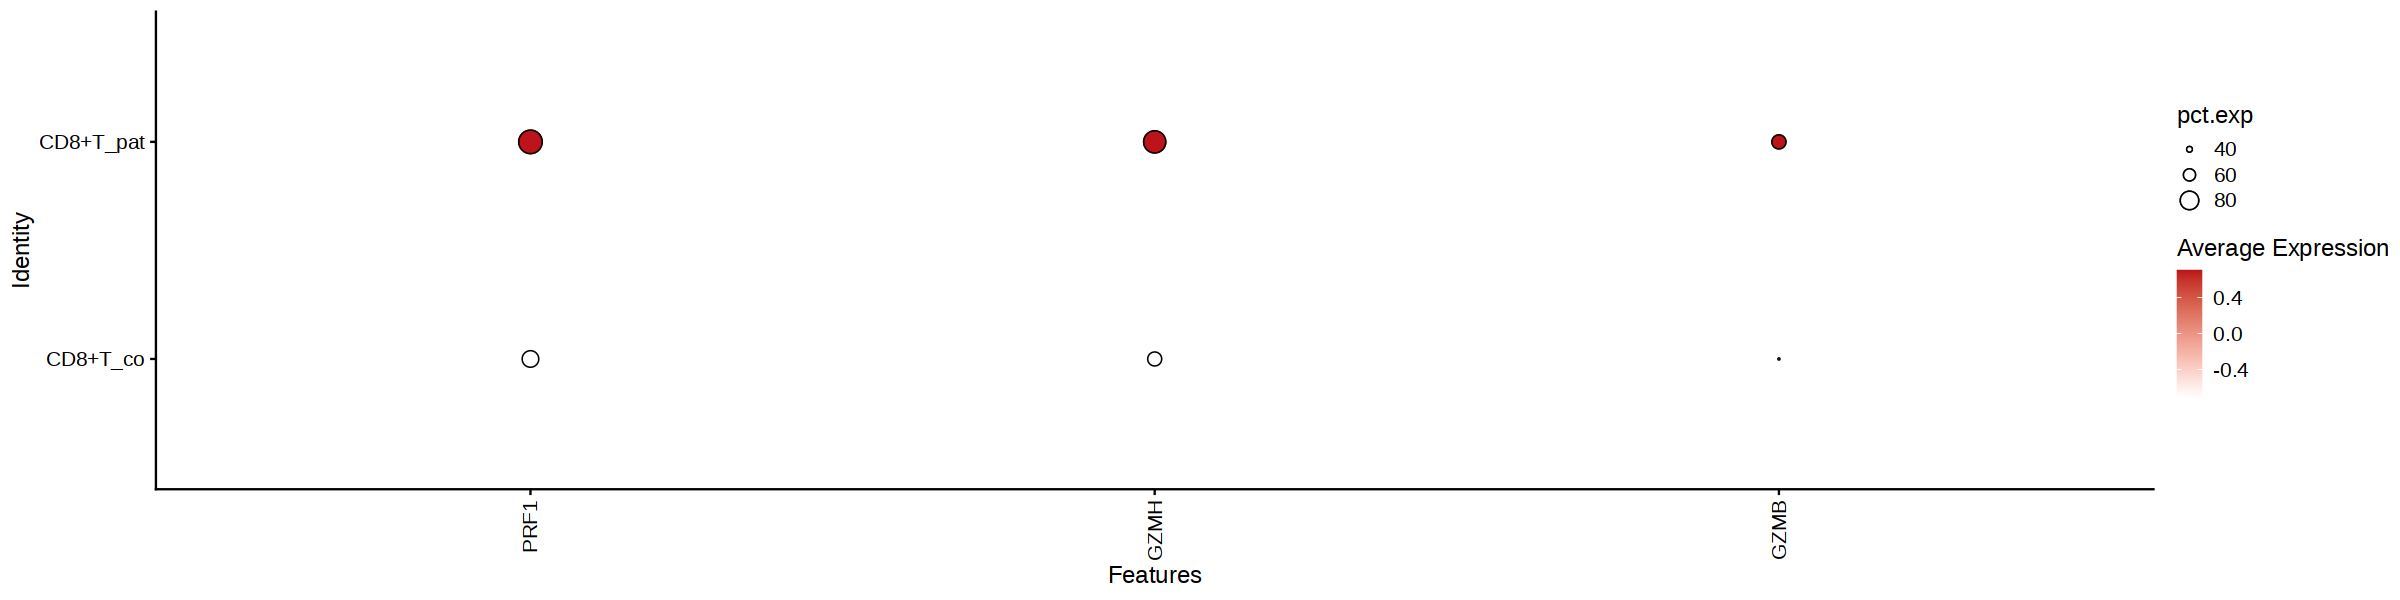

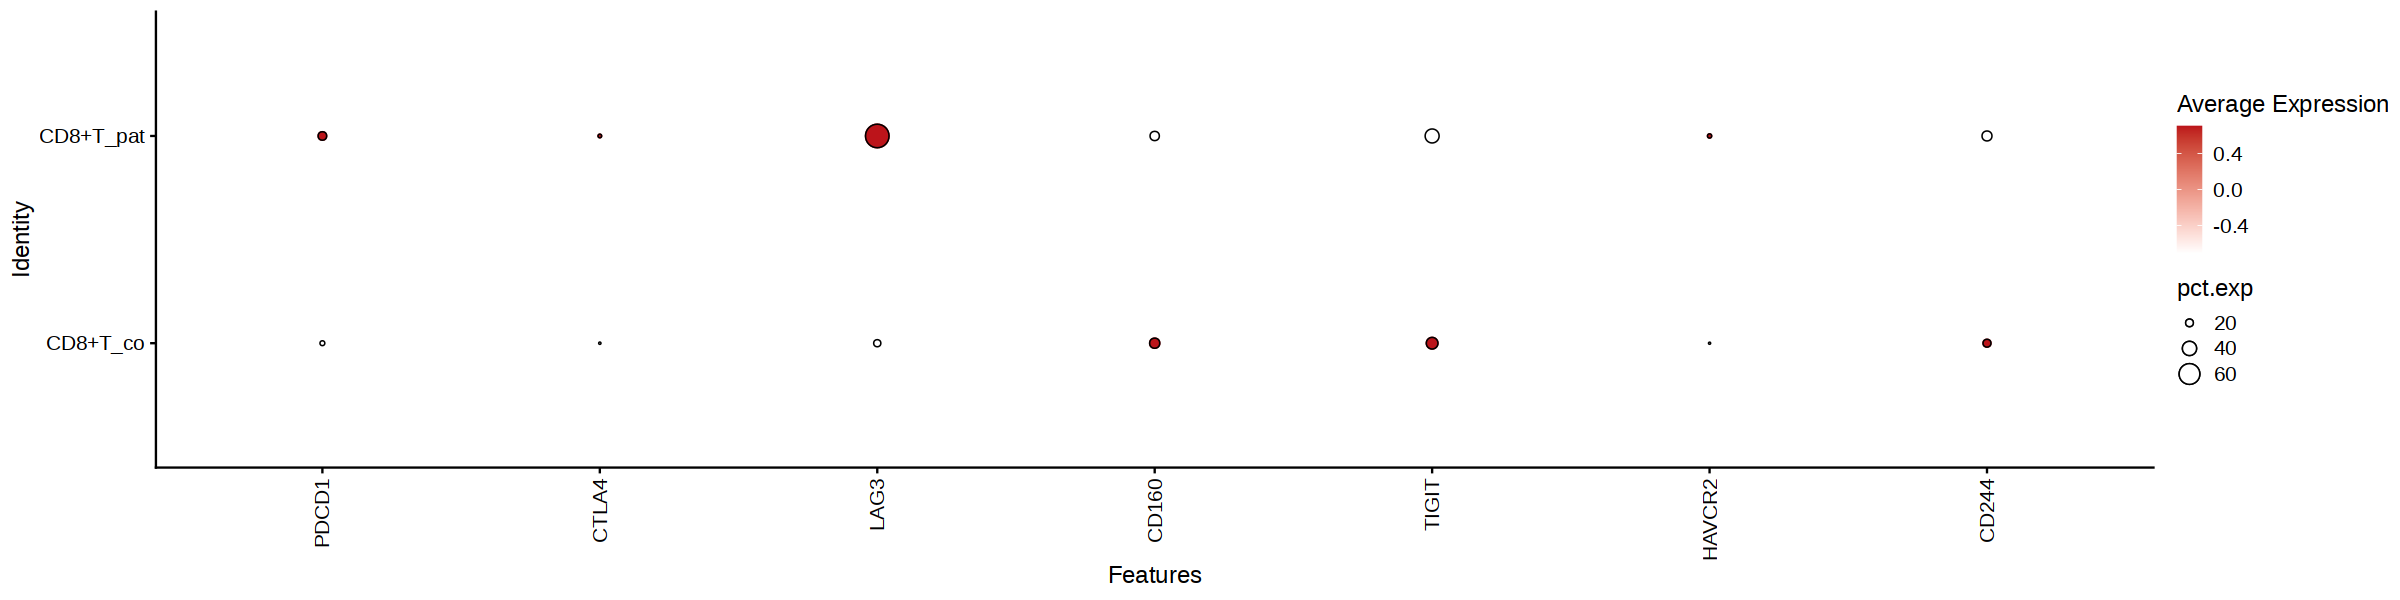

In [32]:
SO.integrated_CD8_dot_plot <- subset(x = SO.integrated_dot_plot, subset = new_Annotation == "CD8+T")

options(repr.plot.width = 20, repr.plot.height = 5)



#pdf("supp_plots/signature_dotplots.pdf",width = 10,height = 6)
p1 = DotPlot(
  object=SO.integrated_CD8_dot_plot,
  assay = "RNA",
  features=type_1_ISG_signature,
  cols = c("white", "#bc141a"),
  col.min = -2.5,
  col.max = 2.5,
  dot.min = 0,
  dot.scale = 6,
  idents=NULL,
  group.by = NULL,
  split.by = NULL,
  cluster.idents = FALSE,
  scale = TRUE,
  scale.by = "radius",
  scale.min = NA,
  scale.max = NA
)+geom_point(aes(size=pct.exp), shape = 21, colour="black", stroke=0.5) +
  #scale_colour_viridis(option="magma") +
  guides(size=guide_legend(override.aes=list(shape=21, colour="black", fill="white")))+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

p2 = DotPlot(
  object=SO.integrated_CD8_dot_plot,
  assay = "RNA",
  features=cytotoxic_signature,
  cols = c("white", "#bc141a"),
  col.min = -2.5,
  col.max = 2.5,
  dot.min = 0,
  dot.scale = 6,
  idents=NULL,
  group.by = NULL,
  split.by = NULL,
  cluster.idents = FALSE,
  scale = TRUE,
  scale.by = "radius",
  scale.min = NA,
  scale.max = NA
)+geom_point(aes(size=pct.exp), shape = 21, colour="black", stroke=0.5) +
  #scale_colour_viridis(option="magma") +
  guides(size=guide_legend(override.aes=list(shape=21, colour="black", fill="white")))+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


p3 = DotPlot(
  object=SO.integrated_CD8_dot_plot,
  assay = "RNA",
  features=exhaustion_signature,
  cols = c("white", "#bc141a"),
  col.min = -2.5,
  col.max = 2.5,
  dot.min = 0,
  dot.scale = 6,
  idents=NULL,
  group.by = NULL,
  split.by = NULL,
  cluster.idents = FALSE,
  scale = TRUE,
  scale.by = "radius",
  scale.min = NA,
  scale.max = NA
)+geom_point(aes(size=pct.exp), shape = 21, colour="black", stroke=0.5) +
  #scale_colour_viridis(option="magma") +
  guides(size=guide_legend(override.aes=list(shape=21, colour="black", fill="white")))+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


p1
p2
p3
#dev.off()

In [33]:
#importnig gene list of GO terms
GO_Term_Files_names <- list.files("GO_Term_Genes/")

In [34]:
GO_0002237<-read.csv("GO_Term_Genes/GO_0002237.txt",sep="\t",header = FALSE)
GO_0002237<-GO_0002237$V2
GO_0010803<-read.csv("GO_Term_Genes/GO_0010803.txt",sep="\t",header = FALSE)
GO_0010803<-GO_0010803$V2
GO_0032069<-read.csv("GO_Term_Genes/GO_0032069.txt",sep="\t",header = FALSE)
GO_0032069<-GO_0032069$V2
GO_0032496<-read.csv("GO_Term_Genes/GO_0032496.txt",sep="\t",header = FALSE)
GO_0032496<-GO_0032496$V2
GO_0032729<-read.csv("GO_Term_Genes/GO_0032729.txt",sep="\t",header = FALSE)
GO_0032729<-GO_0032729$V2
GO_0043065<-read.csv("GO_Term_Genes/GO_0043065.txt",sep="\t",header = FALSE)
GO_0043065<-GO_0043065$V2
GO_0043066<-read.csv("GO_Term_Genes/GO_0043066.txt",sep="\t",header = FALSE)
GO_0043066<-GO_0043066$V2
GO_0043124<-read.csv("GO_Term_Genes/GO_0043124.txt",sep="\t",header = FALSE)
GO_0043124<-GO_0043124$V2
GO_0050718<-read.csv("GO_Term_Genes/GO_0050718.txt",sep="\t",header = FALSE)
GO_0050718<-GO_0050718$V2
GO_0051092<-read.csv("GO_Term_Genes/GO_0051092.txt",sep="\t",header = FALSE)
GO_0051092<-GO_0051092$V2
GO_0051726<-read.csv("GO_Term_Genes/GO_0051726.txt",sep="\t",header = FALSE)
GO_0051726<-GO_0051726$V2
GO_0071349<-read.csv("GO_Term_Genes/GO_0071349.txt",sep="\t",header = FALSE)
GO_0071349<-GO_0071349$V2

In [35]:
Idents(SO.integrated) <- (SO.integrated@meta.data$new_Annotation)

Warning message:
“The following features are not present in the object: SPDYE21, CHMP4BP1, MACROH2A1, PABIR1, METTL13, SPDYE15, CCNYL2, B2RBV5, SPDYE7P, MEIOSIN, SPDYE11, A6NJR5, MAGEA5P, GPR15LG, ZZZ3, IHO1, H2AX, SPDYE13, SPDYE9, BMAL1, CENATAC, SPDYE12, SPDYE10, SPDYE18, BIRC8, CCNP, SPDYE14, SPDYE8, not searching for symbol synonyms”


[1] "GO_0051726"
[1] 1837   28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 243247, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 182973, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables

Warning message:
“The following features are not present in the object: CARD17P, CYRIB, not searching for symbol synonyms”


[1] "GO_0002237"
[1] 1837   28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 221291, p-value = 5.726e-13
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 154518, p-value = 0.0008891
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables

Warning message:
“The following features are not present in the object: CARD17P, not searching for symbol synonyms”


[1] "GO_0032496"
[1] 1837   28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 216355, p-value = 1.651e-10
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 149602, p-value = 0.01986
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



[1] "GO_0032069"
[1] 1837   28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 222062, p-value = 2.228e-13
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 170517, p-value = 5.395e-11
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables

No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


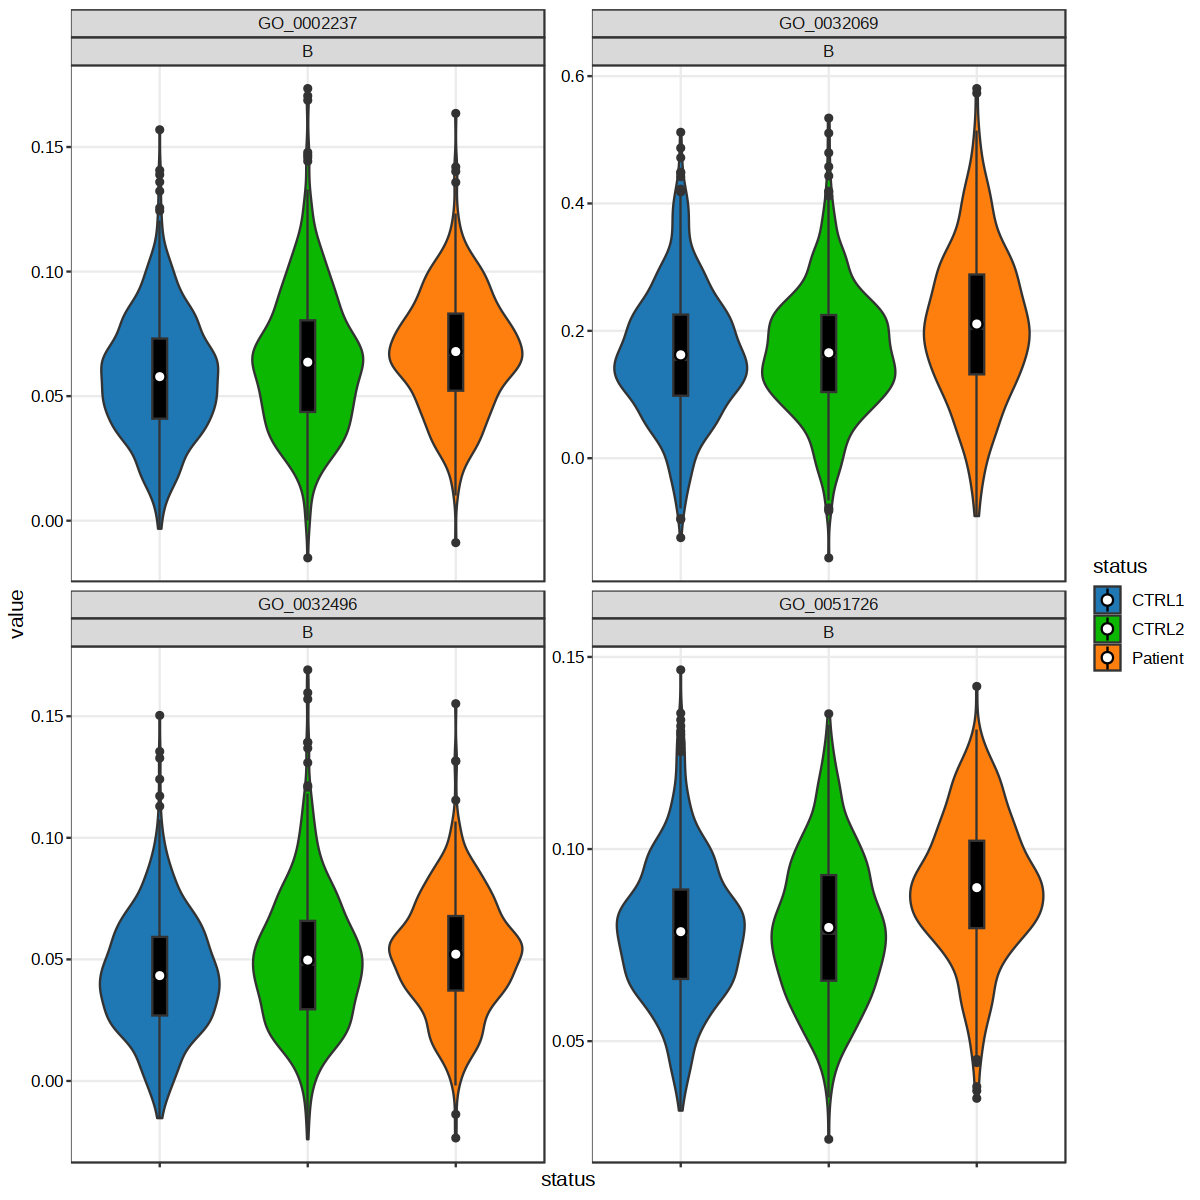

In [36]:
#calculating and visualizing GO term gene expression scores in B cells
status_colors <- c("Patient" = "#FF7F0E", "CTRL1" = "#1F77B4", "CTRL2" = "#0CB702")

options(repr.plot.width = 10, repr.plot.height = 10)

Final_df1 <- data.frame()
B= list(GO_0051726, GO_0002237,GO_0032496, GO_0032069)
names(B)=c("GO_0051726","GO_0002237","GO_0032496", "GO_0032069")
for (names in names(B)) {
    temp_df <- subset(x = SO.integrated, idents = c("B"))
    temp_df <- AddModuleScore(temp_df,features=list(B[[names]]),name=names,assay="RNA")
    print(names)
    print(dim(temp_df@meta.data))
    print(wilcox.test(temp_df@meta.data[temp_df@meta.data$status=="Patient",28],
           temp_df@meta.data[temp_df@meta.data$status=="CTRL1",28]))
    
    print(wilcox.test(temp_df@meta.data[temp_df@meta.data$status=="Patient",28],
           temp_df@meta.data[temp_df@meta.data$status=="CTRL2",28]))
    #print(head(temp_df))
    #print(wilcox.test())
    #print(head(temp_df@meta.data))
    #print(paste(names,"1"))
    df<-melt(temp_df@meta.data[,c(paste0(names,"1"),"new_Annotation","status")])
    df$variable <- substr(df$variable,1,(nchar(as.character(df$variable))-1))
    #print(head(df))
    Final_df1<- rbind(Final_df1,df)
}

#pdf("supp_plots/B_GO_scores.pdf",height=6,width = 6)

    ggplot(Final_df1,aes(y=value,x=status,fill=status))+geom_violin()+geom_boxplot(width=0.1,fill="black")+facet_wrap(~variable+new_Annotation,scales = "free_y")+stat_summary()+
scale_fill_manual(values=status_colors)+
  stat_summary(fun=mean, geom="point",color="white")+theme(axis.line=element_blank(),axis.text.x=element_blank())

#dev.off()

[1] "GO_0071349"
[1] 604  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 19991, p-value = 0.6166
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 18400, p-value = 0.2028
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables

Warning message:
“The following features are not present in the object: NAT8B, QARS1, GPX1, MTRNR2L2, MARCHF7, GBA1, PRAMEF22, MTRNR2L9, MT-RNR2, C8orf17, AARS1, BIRC8, GPRASP3, not searching for symbol synonyms”


[1] "GO_0043066"
[1] 604  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 27861, p-value = 4.551e-08
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 25215, p-value = 6.679e-05
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



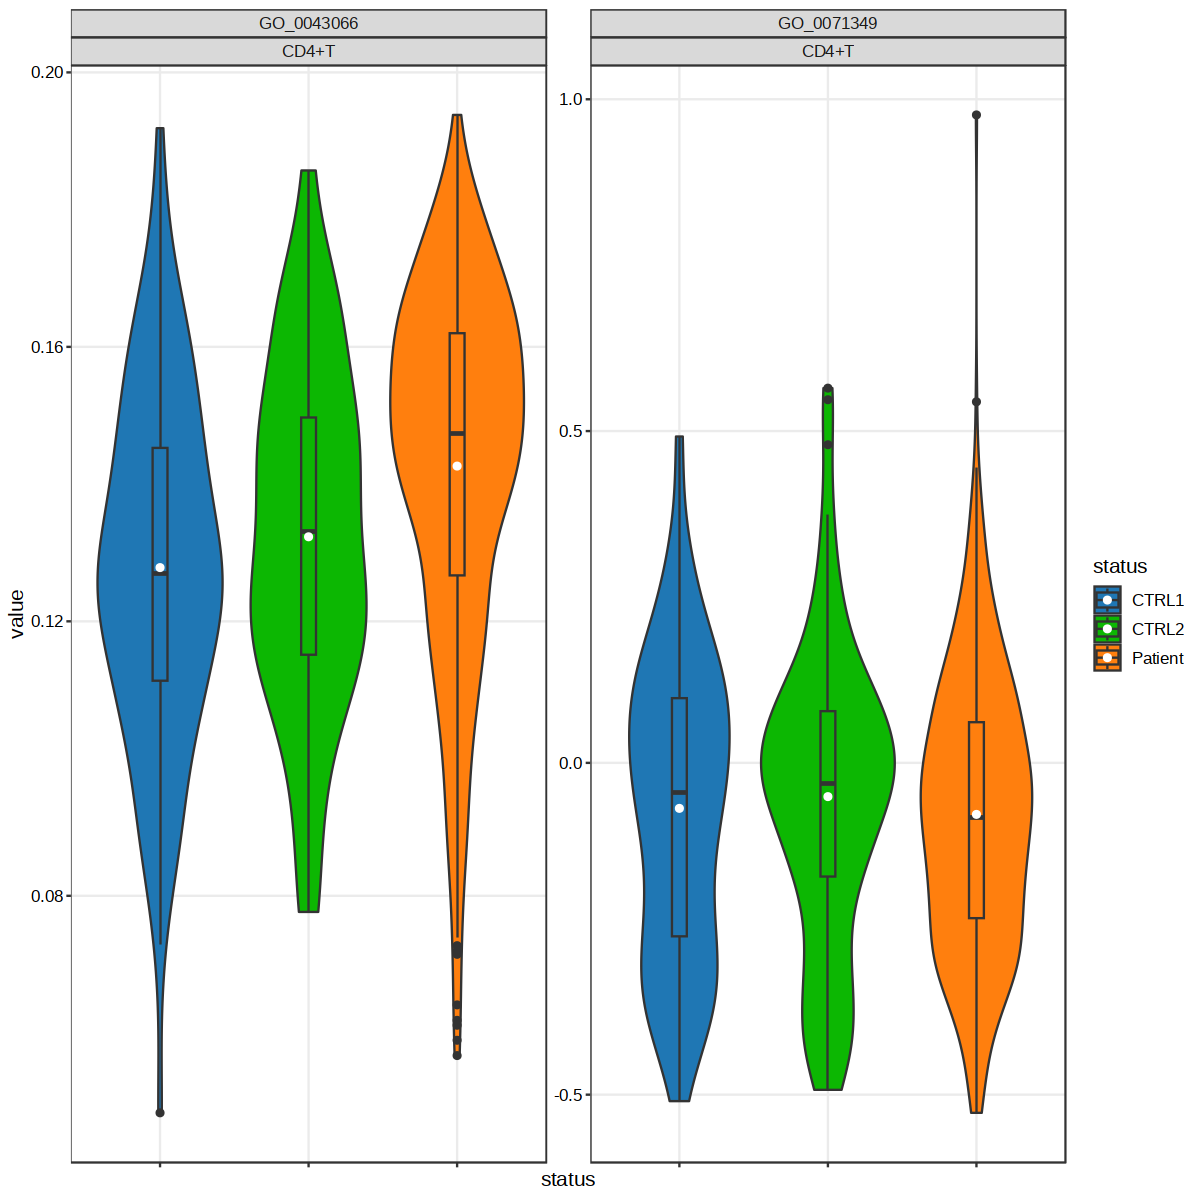

In [37]:
#calculating and visualizing GO term gene expression scores in CD4+T cells
Final_df2 <- data.frame()
B= list(GO_0071349, GO_0043066)
names(B)=c("GO_0071349", "GO_0043066")
for (names in names(B)) {
    temp_df <- subset(x = SO.integrated, idents = c("CD4+T"))
    temp_df <- AddModuleScore(temp_df,features=list(B[[names]]),name=names,assay="RNA")
      print(names)
    print(dim(temp_df@meta.data))
    print(wilcox.test(temp_df@meta.data[temp_df@meta.data$status=="Patient",28],
           temp_df@meta.data[temp_df@meta.data$status=="CTRL1",28]))
    
    print(wilcox.test(temp_df@meta.data[temp_df@meta.data$status=="Patient",28],
           temp_df@meta.data[temp_df@meta.data$status=="CTRL2",28]))
    #print(head(temp_df@meta.data))
    #print(paste(names,"1"))
    df<-melt(temp_df@meta.data[,c(paste0(names,"1"),"new_Annotation","status")])
    df$variable <- substr(df$variable,1,(nchar(as.character(df$variable))-1))
    #print(head(df))
    Final_df2<- rbind(Final_df2,df)
}


#pdf("supp_plots/CD4+T_GO_scores.pdf",height=4,width = 10)

    ggplot(Final_df2,aes(y=value,x=status,fill=status))+geom_violin()+geom_boxplot(width=0.1)+facet_wrap(~variable+new_Annotation,scales = "free_y")+
scale_fill_manual(values=status_colors)+
  stat_summary(fun=mean, geom="point",color="white")+theme(axis.line=element_blank(),axis.text.x=element_blank())
#dev.off()

Warning message:
“The following features are not present in the object: CYRIB, not searching for symbol synonyms”


[1] "GO_0032729"
[1] 894  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 47678, p-value = 1.999e-15
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 90571, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables

Warning message:
“The following features are not present in the object: H2BC11, not searching for symbol synonyms”


[1] "GO_0010803"
[1] 894  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 39969, p-value = 0.0002113
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 80532, p-value = 1.518e-06
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



[1] "GO_0050718"
[1] 894  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 36497, p-value = 0.0723
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 72971, p-value = 0.02892
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



[1] "GO_0043065"
[1] 894  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 46270, p-value = 7.627e-13
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 92766, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



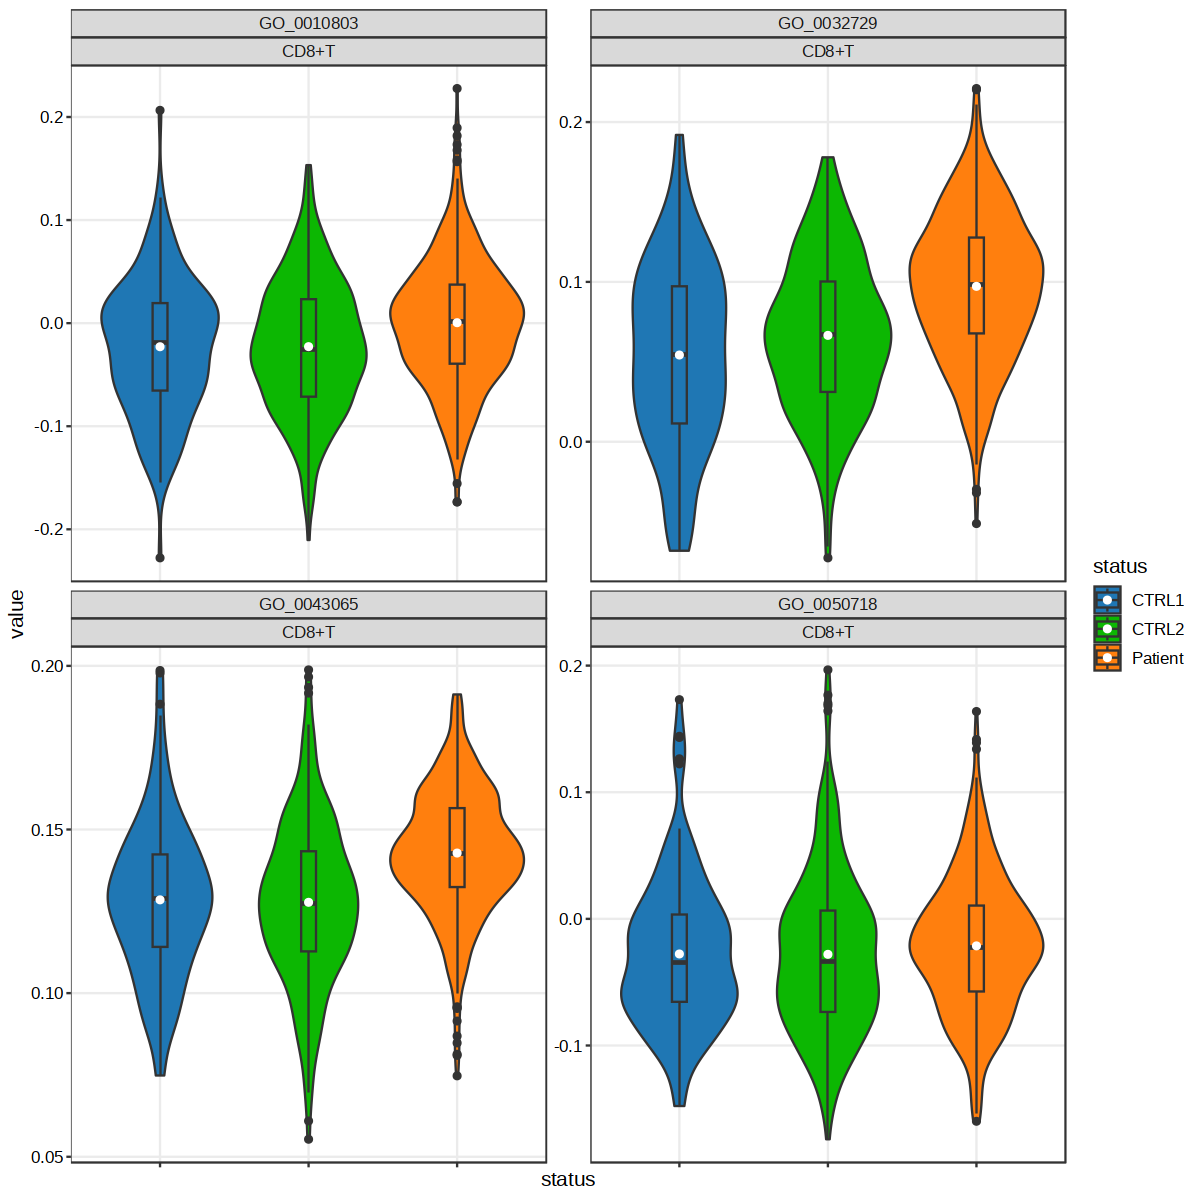

In [38]:
#calculating and visualizing GO term gene expression scores in CD8+T cells
Final_df3 <- data.frame()
B= list(GO_0032729, GO_0010803, GO_0050718, GO_0043065)
names(B)=c("GO_0032729", "GO_0010803", "GO_0050718", "GO_0043065")
for (names in names(B)) {
    temp_df <- subset(x = SO.integrated, idents = c("CD8+T"))
    temp_df <- AddModuleScore(temp_df,features=list(B[[names]]),name=names,assay="RNA")
      print(names)
    print(dim(temp_df@meta.data))
    print(wilcox.test(temp_df@meta.data[temp_df@meta.data$status=="Patient",28],
           temp_df@meta.data[temp_df@meta.data$status=="CTRL1",28]))
    
    print(wilcox.test(temp_df@meta.data[temp_df@meta.data$status=="Patient",28],
           temp_df@meta.data[temp_df@meta.data$status=="CTRL2",28]))
    #print(head(temp_df@meta.data))
    #print(paste(names,"1"))
    df<-melt(temp_df@meta.data[,c(paste0(names,"1"),"new_Annotation","status")])
    df$variable <- substr(df$variable,1,(nchar(as.character(df$variable))-1))
    #print(head(df))
    Final_df3<- rbind(Final_df3,df)
}

#pdf("supp_plots/CD8+T_GO_scores.pdf",height=6,width = 6)

    ggplot(Final_df3,aes(y=value,x=status,fill=status))+geom_violin()+geom_boxplot(width=0.1)+facet_wrap(~variable+new_Annotation,scales = "free_y")+
scale_fill_manual(values=status_colors)+
  stat_summary(fun=mean, geom="point",color="white")+theme(axis.line=element_blank(),axis.text.x=element_blank())
#dev.off()

[1] "GO_0050718"
[1] 321  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 10214, p-value = 2.627e-06
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 7807, p-value = 2.617e-08
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



[1] "GO_0043065"
[1] 321  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 8347, p-value = 0.1513
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 7710, p-value = 8.702e-08
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



[1] "GO_0051092"
[1] 321  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 12406, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 8059, p-value = 9.379e-10
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables

Warning message:
“The following features are not present in the object: CARD17P, not searching for symbol synonyms”


[1] "GO_0032496"
[1] 321  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 8912, p-value = 0.01542
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 7270, p-value = 1.165e-05
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



[1] "GO_0032069"
[1] 321  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 11246, p-value = 7.939e-11
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 8649, p-value = 1.194e-13
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



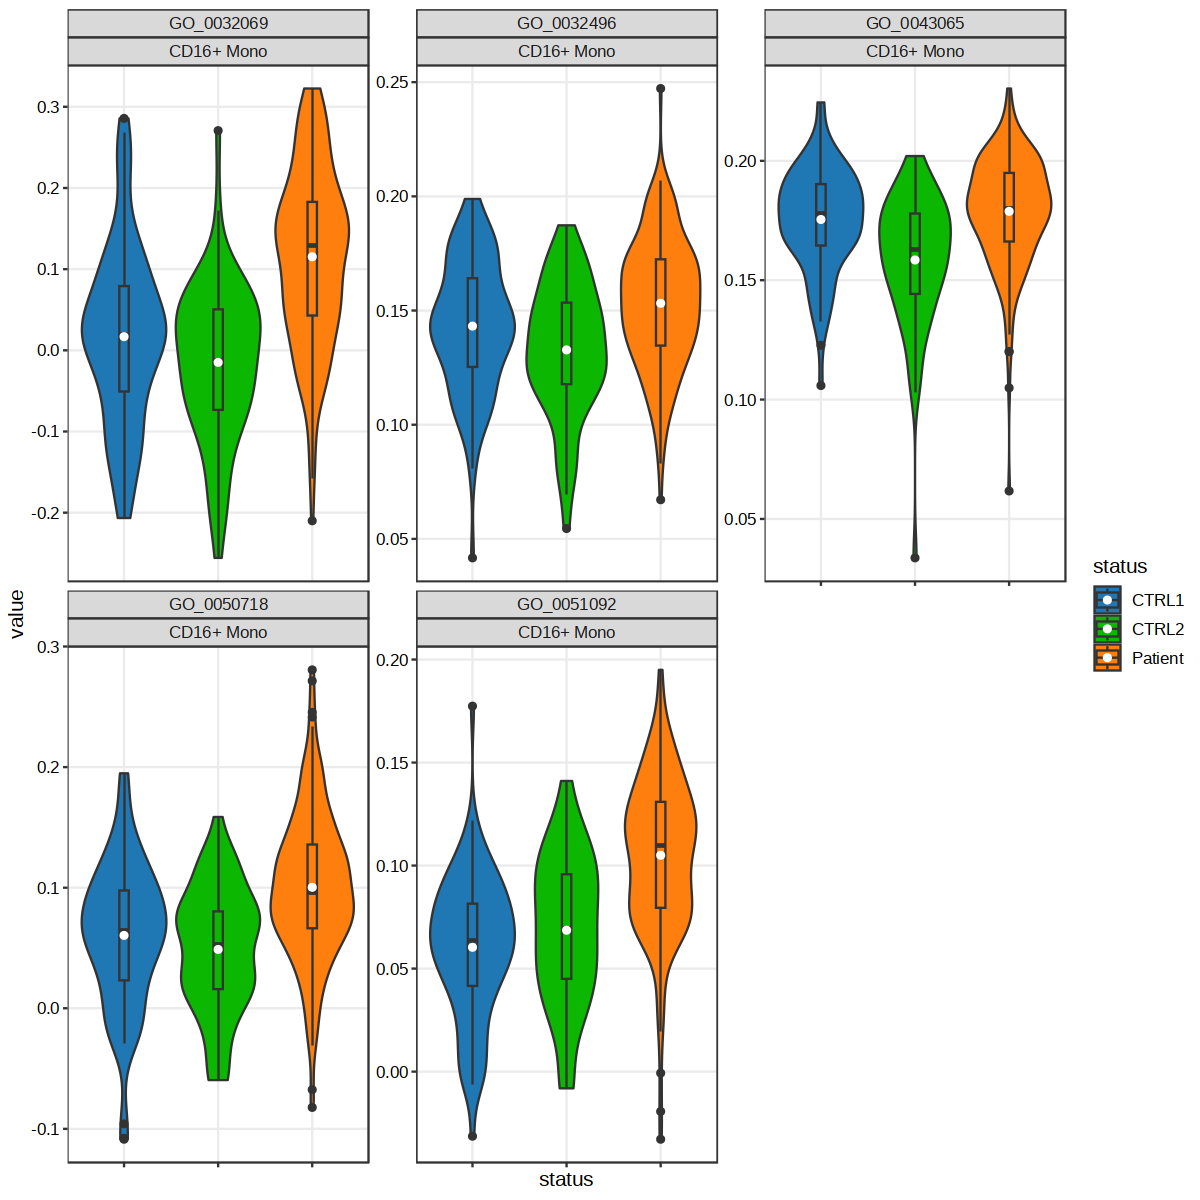

In [39]:
#calculating and visualizing GO term gene expression scores in CD16+ Mono cells
Final_df4 <- data.frame()
B= list(GO_0050718, GO_0043065, GO_0051092, GO_0032496, GO_0032069)
names(B)=c("GO_0050718", "GO_0043065", "GO_0051092", "GO_0032496", "GO_0032069")
for (names in names(B)) {
    temp_df <- subset(x = SO.integrated, idents = c("CD16+ Mono"))
    temp_df <- AddModuleScore(temp_df,features=list(B[[names]]),name=names,assay="RNA")
      print(names)
    print(dim(temp_df@meta.data))
    print(wilcox.test(temp_df@meta.data[temp_df@meta.data$status=="Patient",28],
           temp_df@meta.data[temp_df@meta.data$status=="CTRL1",28]))
    
    print(wilcox.test(temp_df@meta.data[temp_df@meta.data$status=="Patient",28],
           temp_df@meta.data[temp_df@meta.data$status=="CTRL2",28]))
    #print(head(temp_df@meta.data))
    #print(paste(names,"1"))
    df<-melt(temp_df@meta.data[,c(paste0(names,"1"),"new_Annotation","status")])
    df$variable <- substr(df$variable,1,(nchar(as.character(df$variable))-1))
    #print(head(df))
    Final_df4<- rbind(Final_df4,df)
}

#pdf("supp_plots/CD16+ Mono_GO_scores.pdf",height=6,width = 6)

    ggplot(Final_df4,aes(y=value,x=status,fill=status))+geom_violin()+geom_boxplot(width=0.1)+facet_wrap(~variable+new_Annotation,scales = "free_y")+
scale_fill_manual(values=status_colors)+
  stat_summary(fun=mean, geom="point",color="white")+theme(axis.line=element_blank(),axis.text.x=element_blank())
#dev.off()

[1] "GO_0043065"
[1] 2510   28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 546593, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 520194, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



[1] "GO_0043124"
[1] 2510   28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 467267, p-value = 0.00205
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 305589, p-value = 7.477e-06
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



[1] "GO_0051092"
[1] 2510   28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 626048, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 513997, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



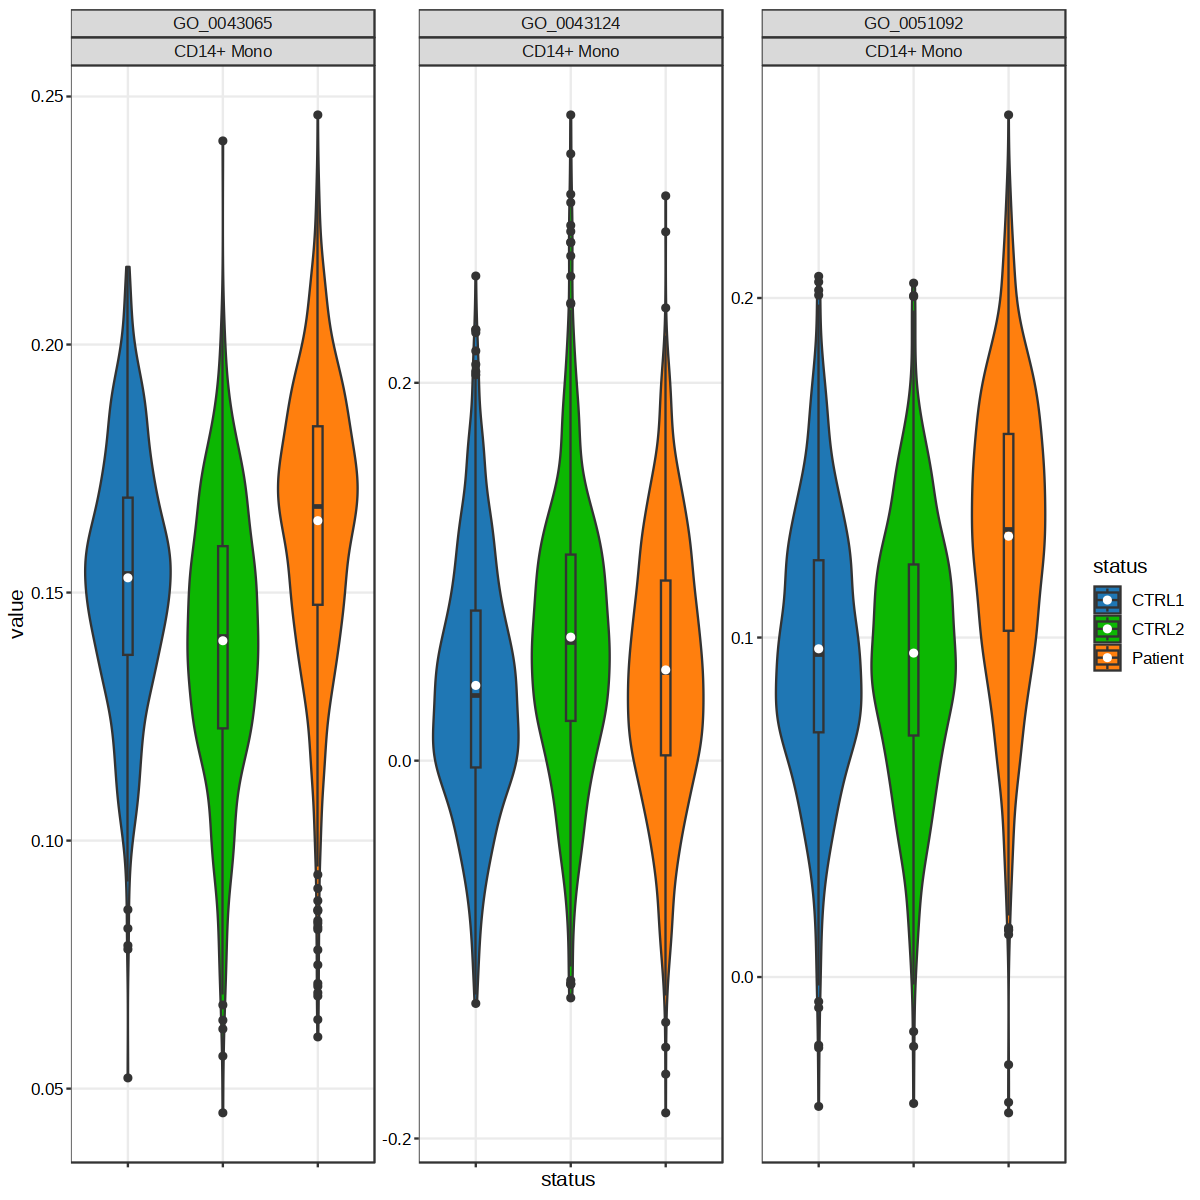

In [40]:
#calculating and visualizing GO term gene expression scores in CD14+ Mono cells

Final_df5 <- data.frame()
B= list(GO_0043065, GO_0043124, GO_0051092)
names(B)=c("GO_0043065", "GO_0043124", "GO_0051092")
for (names in names(B)) {
    temp_df <- subset(x = SO.integrated, idents = c("CD14+ Mono"))
    temp_df <- AddModuleScore(temp_df,features=list(B[[names]]),name=names,assay="RNA")
      print(names)
    print(dim(temp_df@meta.data))
    print(wilcox.test(temp_df@meta.data[temp_df@meta.data$status=="Patient",28],
           temp_df@meta.data[temp_df@meta.data$status=="CTRL1",28]))
    
    print(wilcox.test(temp_df@meta.data[temp_df@meta.data$status=="Patient",28],
           temp_df@meta.data[temp_df@meta.data$status=="CTRL2",28]))
    #print(head(temp_df@meta.data))
    #print(paste(names,"1"))
    df<-melt(temp_df@meta.data[,c(paste0(names,"1"),"new_Annotation","status")])
    df$variable <- substr(df$variable,1,(nchar(as.character(df$variable))-1))
    #print(head(df))
    Final_df5<- rbind(Final_df5,df)
}


#pdf("supp_plots/CD14+ Mono_GO_scores.pdf",height=4,width = 10)

    ggplot(Final_df5,aes(y=value,x=status,fill=status))+geom_violin()+geom_boxplot(width=0.1)+facet_wrap(~variable+new_Annotation,scales = "free_y")+
scale_fill_manual(values=status_colors)+
  stat_summary(fun=mean, geom="point",color="white")+theme(axis.line=element_blank(),axis.text.x=element_blank())
#dev.off()

Warning message:
“The following features are not present in the object: CARD17P, not searching for symbol synonyms”


[1] "GO_0032496"
[1] 406  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 16789, p-value = 5.259e-15
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 16326, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



[1] "GO_0032069"
[1] 406  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 14755, p-value = 3.129e-07
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 14921, p-value = 5.646e-14
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



[1] "GO_0043065"
[1] 406  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 14229, p-value = 1.006e-05
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 15662, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



[1] "GO_0043124"
[1] 406  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 10992, p-value = 0.9116
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 8226, p-value = 0.03451
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



[1] "GO_0051092"
[1] 406  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 16647, p-value = 2.317e-14
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 15081, p-value = 9.468e-15
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



[1] "GO_0050718"
[1] 406  28

	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL1", 28]
W = 16139, p-value = 3.498e-12
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  temp_df@meta.data[temp_df@meta.data$status == "Patient", 28] and temp_df@meta.data[temp_df@meta.data$status == "CTRL2", 28]
W = 15224, p-value = 1.836e-15
alternative hypothesis: true location shift is not equal to 0



Warning message in melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp_df@meta.data[, c(paste0(names, "1"), "new_Annotation", "status")]). In the next version, this warning will become an error.”
Using new_Annotation, status as id variables



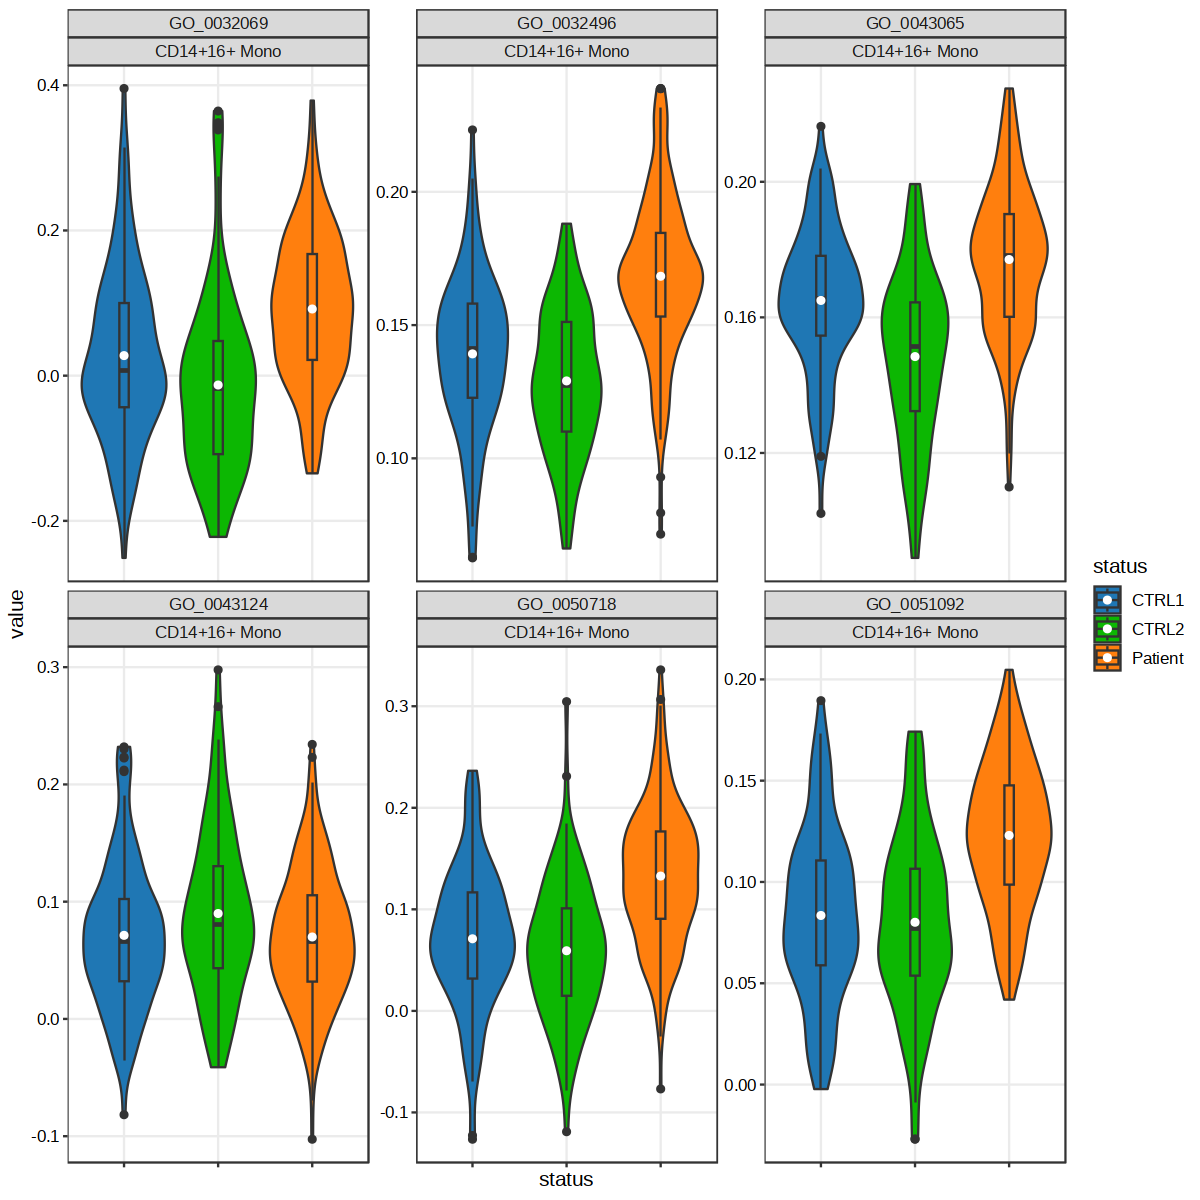

In [41]:
#calculating and visualizing GO term gene expression scores in CD14+16+ Mono cells

Final_df6 <- data.frame()
B= list(GO_0032496, GO_0032069, GO_0043065, GO_0043124, GO_0051092,GO_0050718)
names(B)=c("GO_0032496", "GO_0032069", "GO_0043065", "GO_0043124", "GO_0051092","GO_0050718")
for (names in names(B)) {
    temp_df <- subset(x = SO.integrated, idents = c("CD14+16+ Mono"))
    temp_df <- AddModuleScore(temp_df,features=list(B[[names]]),name=names,assay="RNA")
          print(names)
    print(dim(temp_df@meta.data))
    print(wilcox.test(temp_df@meta.data[temp_df@meta.data$status=="Patient",28],
           temp_df@meta.data[temp_df@meta.data$status=="CTRL1",28]))
    
    print(wilcox.test(temp_df@meta.data[temp_df@meta.data$status=="Patient",28],
           temp_df@meta.data[temp_df@meta.data$status=="CTRL2",28]))
    #print(head(temp_df@meta.data))
    #print(paste(names,"1"))
    df<-melt(temp_df@meta.data[,c(paste0(names,"1"),"new_Annotation","status")])
    df$variable <- substr(df$variable,1,(nchar(as.character(df$variable))-1))
    #print(head(df))
    Final_df6<- rbind(Final_df6,df)
}

#pdf("supp_plots/CD14_16+ Mono_GO_scores.pdf",height=4,width = 10)

    ggplot(Final_df6,aes(y=value,x=status,fill=status))+geom_violin()+geom_boxplot(width=0.1)+facet_wrap(~variable+new_Annotation,scales = "free_y")+
scale_fill_manual(values=status_colors)+
  stat_summary(fun=mean, geom="point",color="white")+theme(axis.line=element_blank(),axis.text.x=element_blank())
#dev.off()

In [42]:
total_df <- data.frame()
total_df <- rbind(Final_df1,total_df)
total_df <- rbind(Final_df2,total_df)
total_df <- rbind(Final_df3,total_df)
total_df <- rbind(Final_df4,total_df)
total_df <- rbind(Final_df5,total_df)
total_df <- rbind(Final_df6,total_df)

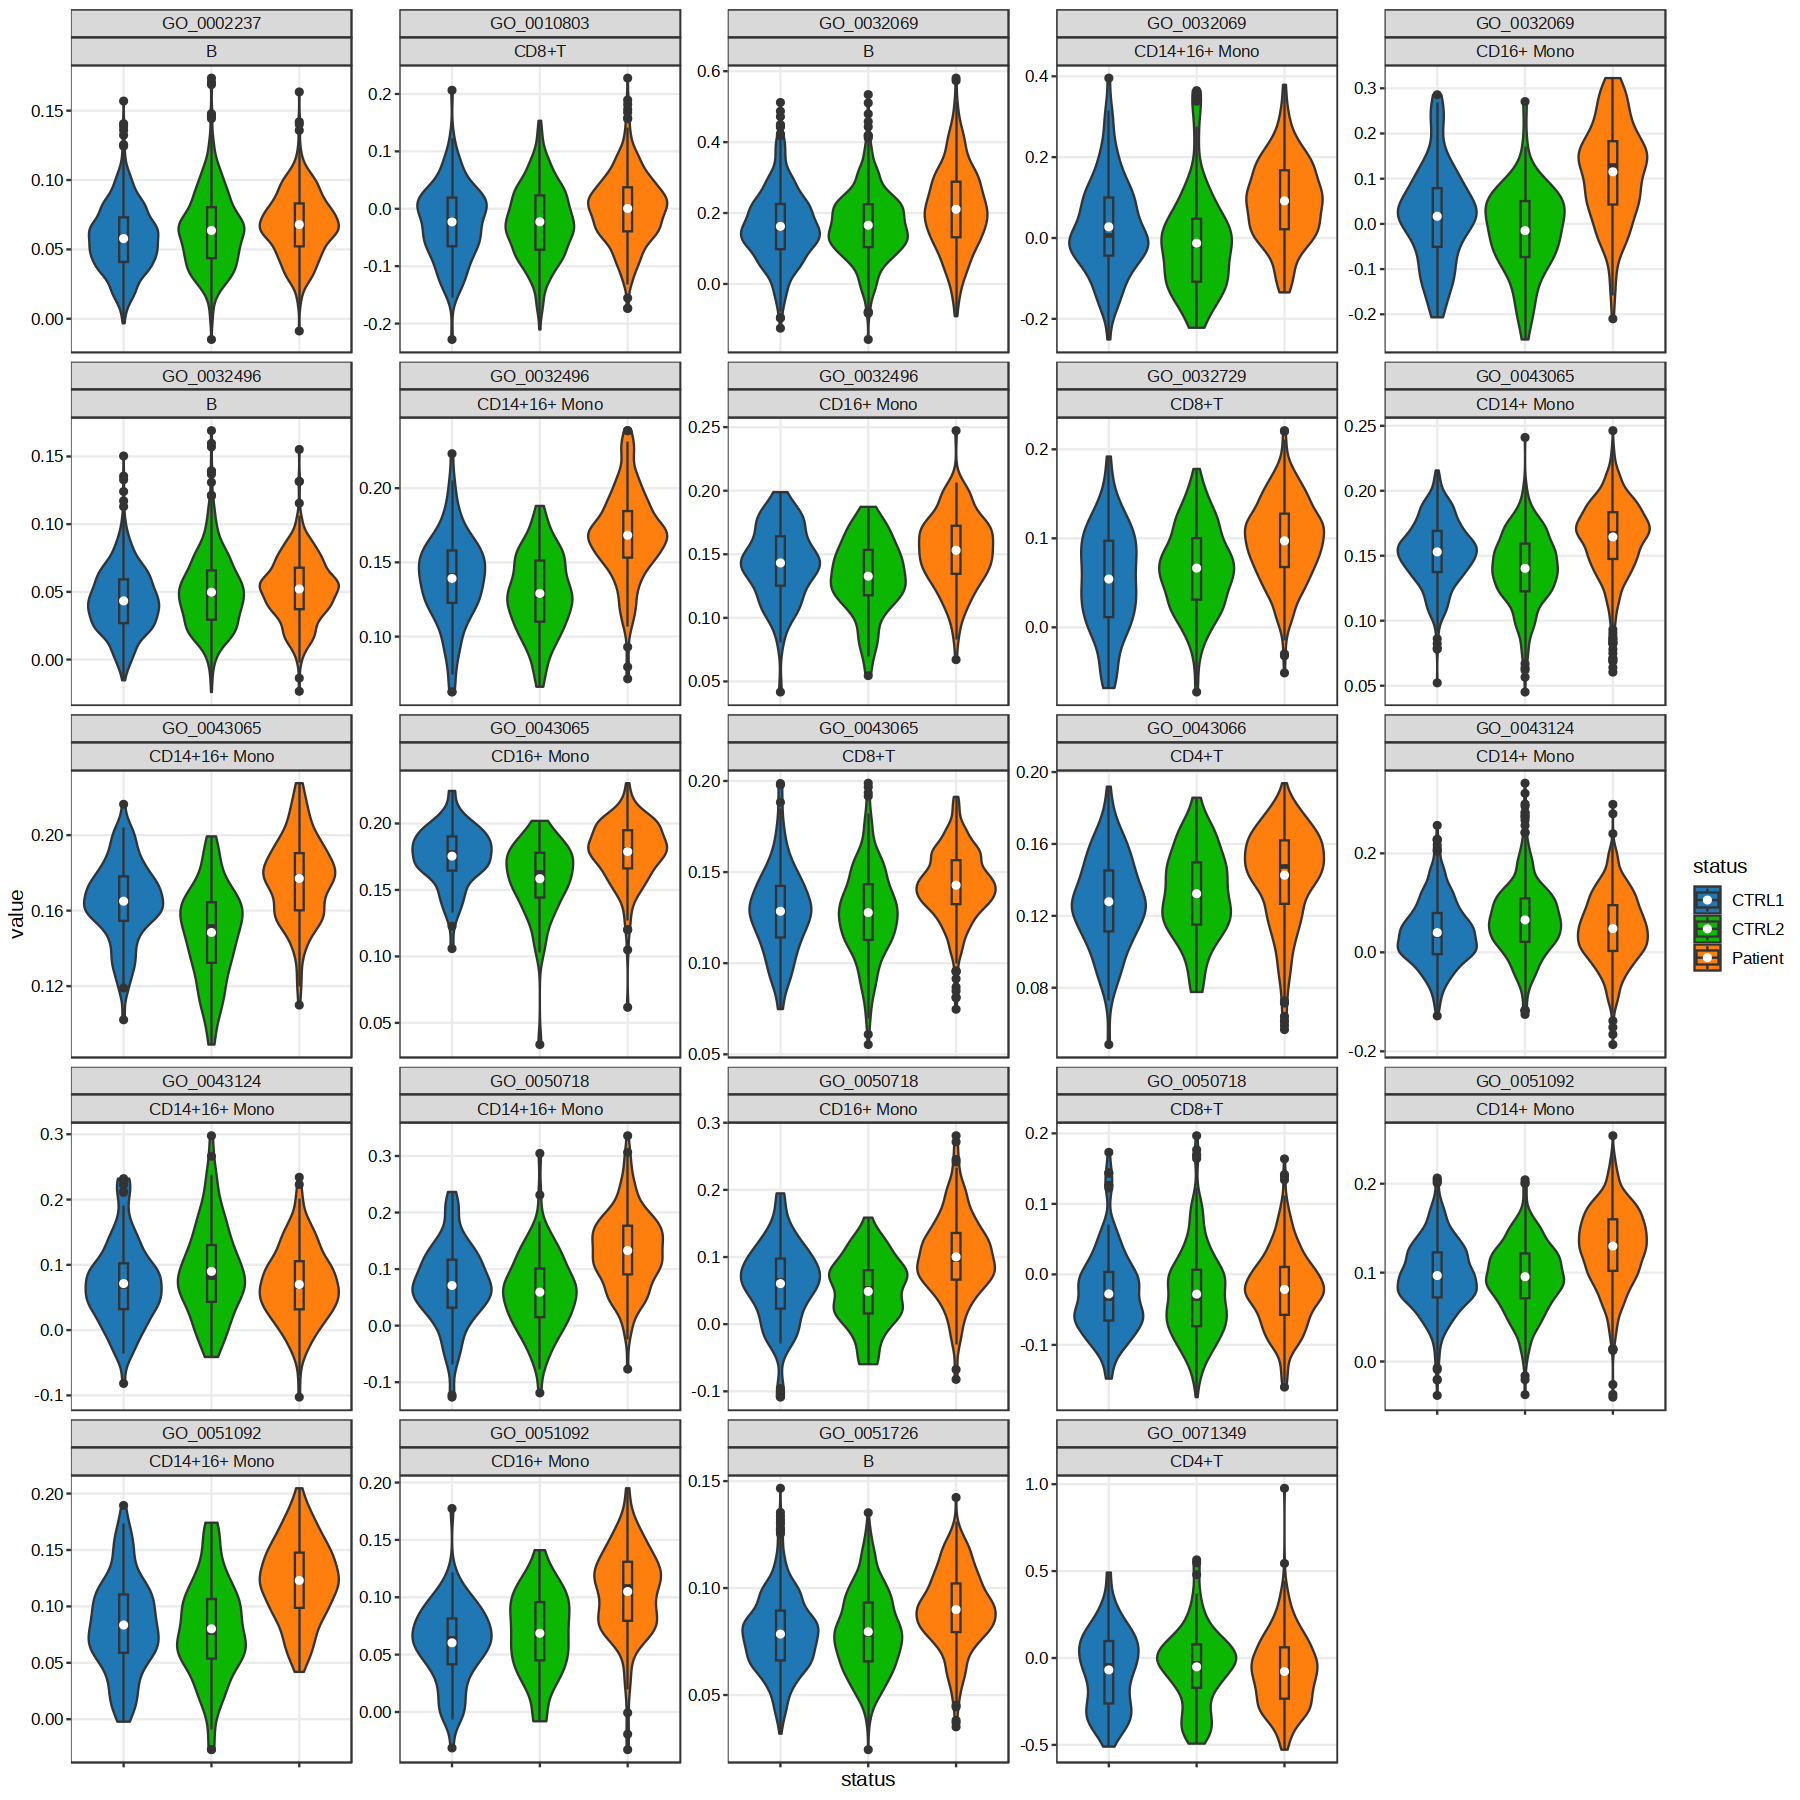

In [43]:
#plotting all GO term gene expression scores
options(repr.plot.width = 15, repr.plot.height = 15)

#pdf("supp_plots/All_GO_scores.pdf",height=15,width = 8)
ggplot(total_df,aes(y=value,x=status,fill=status))+geom_violin()+geom_boxplot(width=0.1)+facet_wrap(~variable+new_Annotation,scales = "free_y")+
scale_fill_manual(values=status_colors)+
  stat_summary(fun=mean, geom="point",color="white")+theme(axis.line=element_blank(),axis.text.x=element_blank())
#dev.off()

In [44]:
#subsetting the pDCs
SO.integrated_pDCs <- subset(x = SO.integrated, subset = minimal_status_cell_type == "Patient_pDCs")
Idents(SO.integrated_pDCs) <- SO.integrated_pDCs@meta.data$minimal_status_cell_type


Warning message:
“Could not find TLR3 in the default search locations, found in RNA assay instead”
Warning message in cor(x = data[, 1], y = data[, 2]):
“the standard deviation is zero”
Warning message:
“Could not find TLR7 in the default search locations, found in RNA assay instead”
Warning message:
“Could not find TLR8 in the default search locations, found in RNA assay instead”
Warning message:
“Could not find TLR3 in the default search locations, found in RNA assay instead”
Warning message in cor(x = data[, 1], y = data[, 2]):
“the standard deviation is zero”
Warning message:
“Could not find TLR7 in the default search locations, found in RNA assay instead”
Warning message:
“Could not find TLR8 in the default search locations, found in RNA assay instead”
Warning message:
“Could not find IFNA4 in the default search locations, found in RNA assay instead”
Warning message:
“Could not find TLR3 in the default search locations, found in RNA assay instead”
Warning message in cor(x = data[,

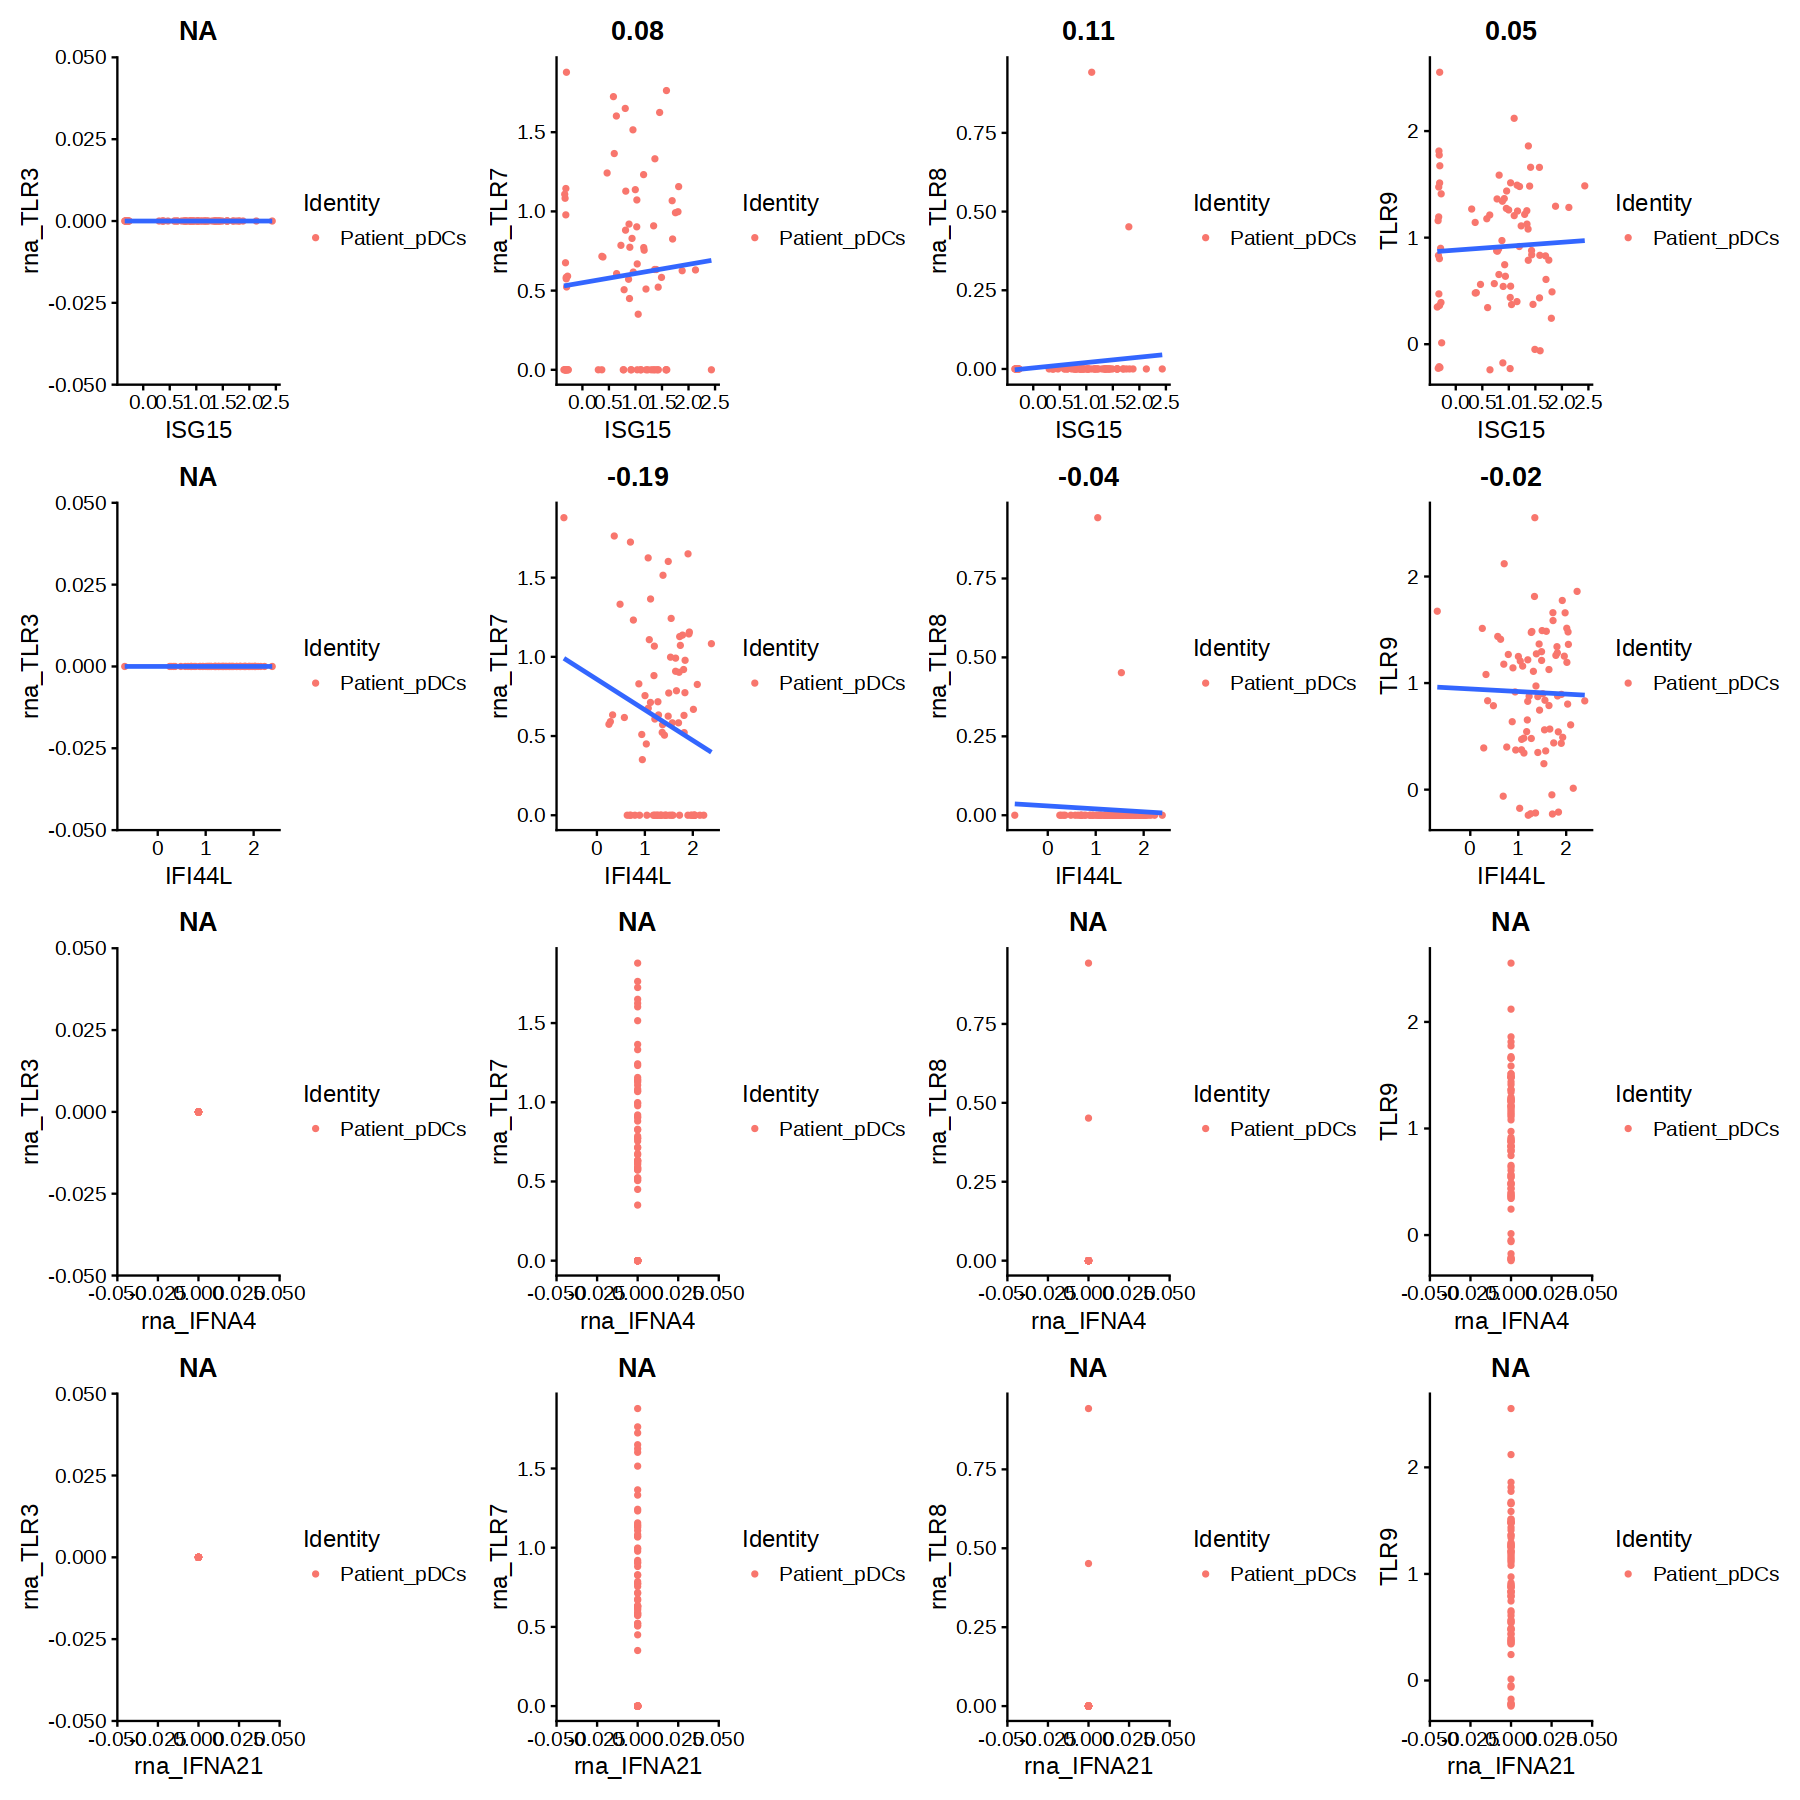

In [45]:
#visualization of the specific gene expression in pDCs using scatter plot
P1 <- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'ISG15', feature2 = 'TLR3')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)

P2 <- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'ISG15', feature2 = 'TLR7')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)

P3 <- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'ISG15', feature2 = 'TLR8')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)

P4 <- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'ISG15', feature2 = 'TLR9')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)



P5 <- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'IFI44L', feature2 = 'TLR3')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)

P6 <- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'IFI44L', feature2 = 'TLR7')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)

P7 <- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'IFI44L', feature2 = 'TLR8')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)

P8 <- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'IFI44L', feature2 = 'TLR9')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)


P9<- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'IFNA4', feature2 = 'TLR3')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)

P10 <- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'IFNA4', feature2 = 'TLR7')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)

P11 <- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'IFNA4', feature2 = 'TLR8')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)

P12 <- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'IFNA4', feature2 = 'TLR9')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)



P13<- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'IFNA21', feature2 = 'TLR3')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)

P14 <- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'IFNA21', feature2 = 'TLR7')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)

P15 <- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'IFNA21', feature2 = 'TLR8')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)

P16 <- FeatureScatter(object = SO.integrated_pDCs, feature1 = 'IFNA21', feature2 = 'TLR9')+  
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)


#pdf("supp_plots/corr_plots.pdf",width=20,height = 20)
P1+P2+P3+P4+P5+P6+P7+P8+P9+P10+P11+P12+P13+P14+P15+P16
#dev.off()

In [46]:
#generating the cell type composition table
df <- table(SO.integrated@meta.data$status_cell_type)

In [47]:
df <- as.data.frame(df)
#df$Var1 <- factor(df$Var1,levels=c())
df$status<-c(rep("Control_1",10),rep("Control_2",10),rep("Patient",10))
df$cell_type<-sub(".*_","",df$Var1 )
df$cell_type <-factor(df$cell_type, levels=c("B","CD4+T","CD8+T","cm-like T","prolif T","CD16+ Mono","CD14+16+ Mono","CD14+ Mono","cDCs","pDCs"))

In [48]:
#write.csv(file="supp_plots/cell_type_count.csv",df)#

Warning message:
“`expand_scale()` was deprecated in ggplot2 3.3.0.
ℹ Please use `expansion()` instead.”


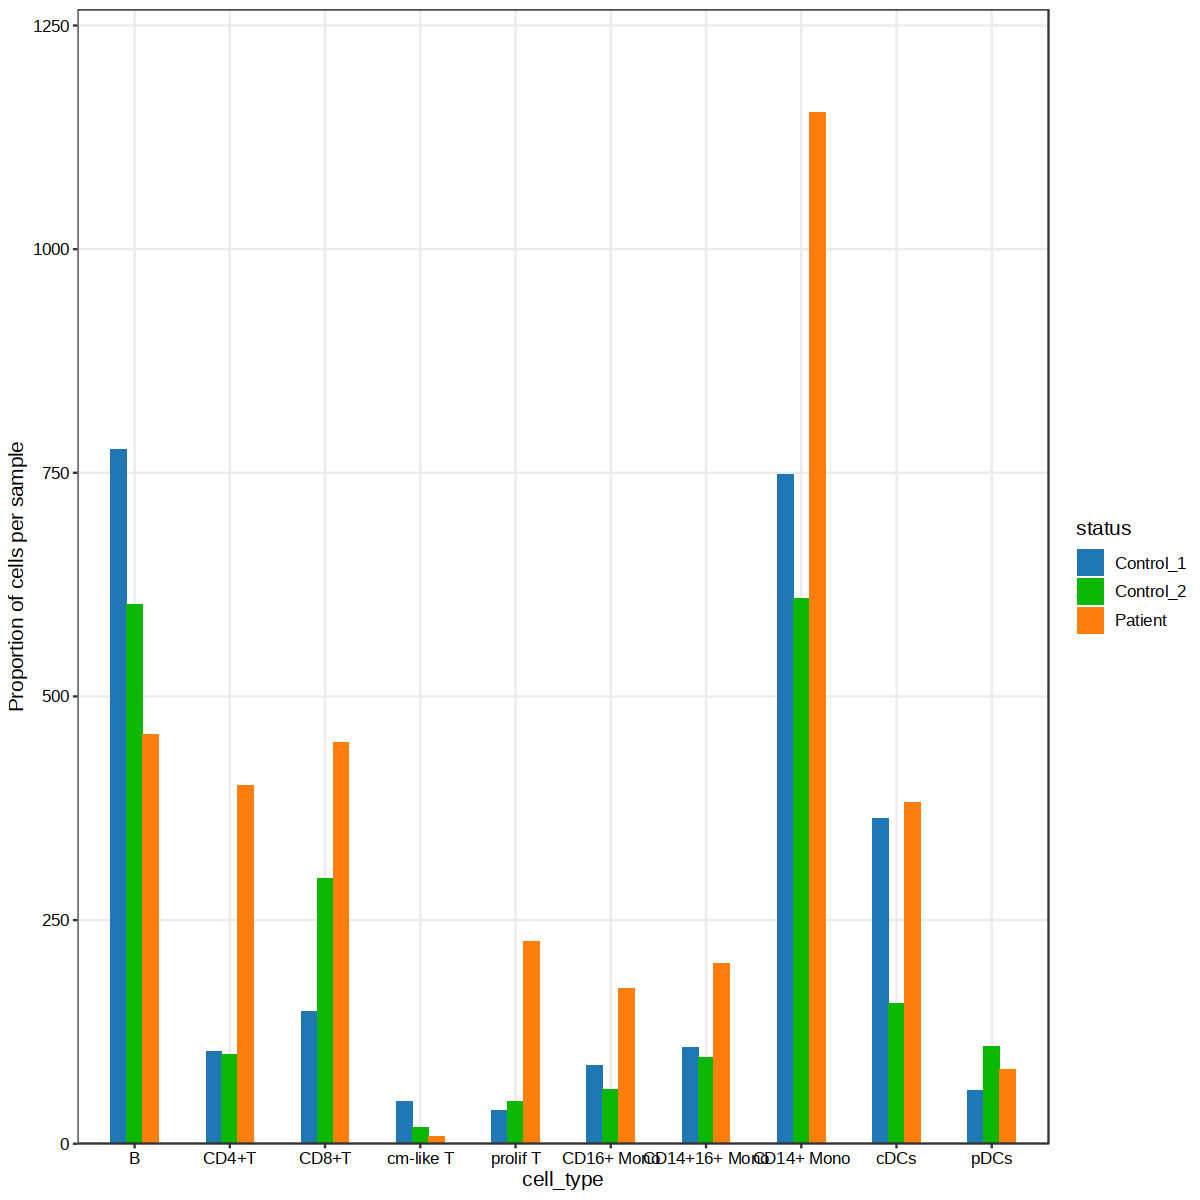

In [49]:
#visualizing the cell type composition plot
options(repr.plot.width = 10, repr.plot.height = 10)
status_colors<- c("Patient" = "#FF7F0E", "Control_1" = "#1F77B4", "Control_2" = "#0CB702")

 #"CTRL1" = "#1F77B4", 

plot <- ggplot(df, aes(cell_type, Freq, fill=status))+scale_fill_manual(values=status_colors)+
     scale_y_continuous(expand = expand_scale(mult = c(0, .1)))+ylab("Proportion of cells per sample")

plot <- plot + geom_bar(stat = "identity", position = 'dodge',width = 0.5)
#pdf("supp_plots/cell_type_proportion.pdf",width = 12,height = 8)
plot
#dev.off()